In [1]:
import pandas as pd
import numpy as np
import os
from os.path import join
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import itertools

In [2]:
# use the following code to load dataset in your notebook

with open("../data/processed/processed_sub_dataset.pkl", "rb") as f:
    data_sub = pickle.load(f)
print("Sub dataset keys:", data_sub.keys())

with open("../data/processed/processed_full_dataset.pkl", "rb") as f:
    data_full = pickle.load(f)
print("Full dataset keys:", data_full.keys())

# Assign variables for sub dataset
X_train_sub = data_sub["X_train_sub"]
y_train_sub = data_sub["y_train_sub"]
X_val_sub = data_sub["X_val_sub"]
y_val_sub = data_sub["y_val_sub"]
classes_sub = data_sub["classes_sub"]

# Assign variables for full dataset
X_train = data_full["X_train"]
y_train = data_full["y_train"]
X_val = data_full["X_val"]
y_val = data_full["y_val"]
X_test = data_full["X_test"]
y_test = data_full["y_test"]
classes = data_full["classes"]

Sub dataset keys: dict_keys(['X_train_sub', 'y_train_sub', 'X_val_sub', 'y_val_sub', 'classes_sub'])
Full dataset keys: dict_keys(['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test', 'classes'])


# Data Dictionary

### Stanford Dogs Dataset Dictionary Structure
### Data Dictionary
The dataset is organized into a dictionary with the following keys:

Training Data
* X_train_sub: Training images for a smaller subset of classes
* y_train_sub: Training labels for the smaller subset
* X_train: Training images for all 120 dog breed classes
* y_train: Training labels for all classes

Validation Data
* X_val_sub: Validation images for the smaller subset
* y_val_sub: Validation labels for the smaller subset
* X_val: Validation images for all classes
* y_val: Validation labels for all classes

Test Data
* X_test: Test images for all classes
* y_test: Test labels for all classes

Class Information
* classes: Array of all 120 dog breed class names
* classes_sub: Array of class names for the smaller subset


In [5]:
# Print some info to verify the data loaded correctly:
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Number of classes:", len(classes))
print("First few classes:", classes[:5])

Training data shape: (12000, 64, 64, 3)
Training labels shape: (12000,)
Number of classes: 120
First few classes: ['affenpinscher' 'afghan_hound' 'african_hunting_dog' 'airedale'
 'american_staffordshire_terrier']


In [17]:
classes_sub

array(['flat', 'german_short', 'american_staffordshire_terrier',
       'ibizan_hound', 'cairn', 'kerry_blue_terrier', 'maltese_dog',
       'bedlington_terrier', 'english_setter', 'sussex_spaniel'],
      dtype='<U30')

# Stage 2: Fully connected neural network (Sub Data)

In [5]:
# Re-encode just the subset data to get consecutive labels
from sklearn.preprocessing import LabelEncoder

# Create a new encoder just for the subset
subset_encoder = LabelEncoder()

# Fit and transform just the subset data
y_train_sub_encoded = subset_encoder.fit_transform(y_train_sub)
y_val_sub_encoded = subset_encoder.transform(y_val_sub)

# Check the results
print("Unique values in y_train_sub_encoded:", np.unique(y_train_sub_encoded))
print("Number of unique classes:", len(np.unique(y_train_sub_encoded)))
print("Min value:", np.min(y_train_sub_encoded))
print("Max value:", np.max(y_train_sub_encoded))

# Now your labels should be 0, 1, 2, 3, 4, 5, 6, 7, 8, 9

Unique values in y_train_sub_encoded: [0 1 2 3 4 5 6 7 8 9]
Number of unique classes: 10
Min value: 0
Max value: 9


In [6]:
def build_model(n_classes,
                input_shape=(64, 64, 3),
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01,
                metric='metric'):
    """Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of output classes in the dataset.
    input_shape: Shape of input images (height, width, channels).
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.
    metric: The desired metric.

    Returns:
    model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    model = tf.keras.Sequential()
    
    # Change this line to use the input_shape parameter
    model.add(tf.keras.layers.Input(shape=input_shape, name='Input'))
    
    model.add(tf.keras.layers.Flatten(name='Flatten')) #Flatten the input

    for i, units in enumerate(hidden_layer_sizes):
        model.add(tf.keras.layers.Dense(units, activation=activation, name=f"Hidden_{i+1}"))

    model.add(tf.keras.layers.Dense(
        n_classes,
        activation='softmax',
        name='Output',
        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.01)
    ))

    if optimizer == 'SGD':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'Adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise ValueError(f'Unsupported optimizer: {optimizer}')

    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=opt,
        metrics=[metric]
    )

    return model

In [7]:
def train_and_evaluate(X_train, y_train,
                       X_val,   y_val,
                       hidden_layer_sizes=None,
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=1e-3,
                       metric='accuracy',
                       num_epochs=10,
                       batch_size=64):
    """
    Train a dense network (or logistic-regression baseline) on Stanford Dogs data.

    Parameters
    ----------
    X_train, y_train : np.ndarray
        Training images and integer labels.
    X_val,   y_val   : np.ndarray
        Validation images and integer labels.  (Use this again as "test" until you
        create a proper hold-out set.)
    hidden_layer_sizes : list[int] | None
        Example []  -> logistic regression
                [1024, 512] -> two-layer dense net.
    activation : str
        Activation for hidden layers.  ('relu', 'tanh', …)
    optimizer : str
        'Adam' or 'SGD'
    learning_rate : float
        Learning-rate passed to the chosen optimizer.
    metric : str
        Metric name understood by Keras, e.g. 'accuracy'.
    num_epochs : int
        Training epochs.
    batch_size : int
        Mini-batch size.

    Returns
    -------
    model : tf.keras.Model
    """
    hidden_layer_sizes = hidden_layer_sizes or []

    # ------------------------------------------------------------------
    # 1.  Build the model.  n_classes inferred from the label array.
    # ------------------------------------------------------------------
    n_classes = len(np.unique(y_train))
    model = build_model(n_classes=n_classes,
                        hidden_layer_sizes=hidden_layer_sizes,
                        activation=activation,
                        optimizer=optimizer,
                        learning_rate=learning_rate,
                        metric=metric)

    # ------------------------------------------------------------------
    # 2.  Train
    # ------------------------------------------------------------------
    print("Training on %d images, validating on %d images ..."
          % (len(X_train), len(X_val)))

    history = model.fit(
        X_train, y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1
    )

    # ------------------------------------------------------------------
    # 3.  Learning curves
    # ------------------------------------------------------------------
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Validation Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------------
    # 4.  Final metrics on the validation set
    # ------------------------------------------------------------------
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"Final validation accuracy: {val_acc:.4f}")

    return model

Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.1403 - loss: 2.9459 - val_accuracy: 0.0954 - val_loss: 2.2455
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.1655 - loss: 2.1969 - val_accuracy: 0.2371 - val_loss: 2.0571
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.1992 - loss: 2.0635 - val_accuracy: 0.2294 - val_loss: 2.0390
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.2225 - loss: 2.0137 - val_accuracy: 0.1907 - val_loss: 2.0418
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.2585 - loss: 1.9739 - val_accuracy: 0.2474 - val_loss: 2.0166
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.2735 - loss: 1.9187 - val_accuracy: 0.2655 - val_loss: 1.9894
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.3004 - loss: 1.8617 - val_accuracy: 0.2887 - val_loss: 1.9622
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accu

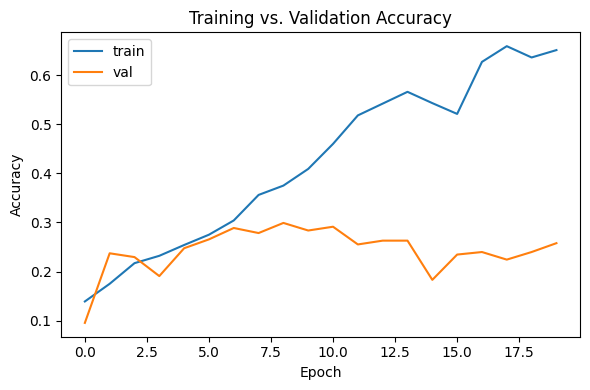

Final validation accuracy: 0.2577


In [17]:
model = train_and_evaluate(
    X_train_sub, y_train_sub_encoded,
    X_val_sub,   y_val_sub_encoded,
    hidden_layer_sizes=[1024, 512],  # or [] for logistic regression
    activation='relu',
    optimizer='Adam',
    learning_rate=1e-3,
    num_epochs=20
)


Testing: hidden_layer_sizes=[1024, 512], activation=relu, optimizer=Adam, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.1046 - loss: 3.1948 - val_accuracy: 0.1082 - val_loss: 2.2769
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.1721 - loss: 2.2421 - val_accuracy: 0.2603 - val_loss: 2.0710
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.2211 - loss: 2.0734 - val_accuracy: 0.2294 - val_loss: 2.0372
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.2339 - loss: 2.0329 - val_accuracy: 0.2603 - val_loss: 2.0390
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.2447 - loss: 1.9623 - val_accuracy: 0.2680 - val_loss: 2.0207
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.2775 - loss: 1.8877 - val_accuracy: 0.2655 - val_loss: 2.0322
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.3239 - lo

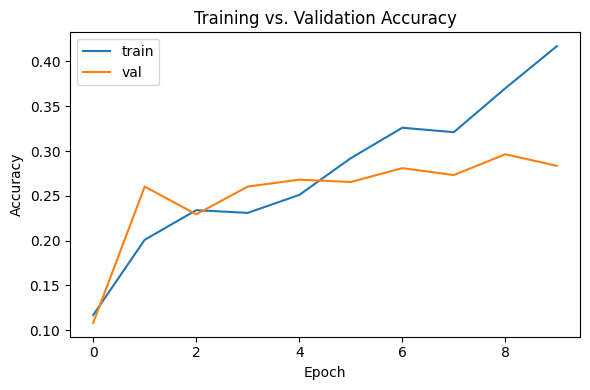

Final validation accuracy: 0.2835

Testing: hidden_layer_sizes=[1024, 512], activation=relu, optimizer=Adam, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.1000 - loss: 3.0563 - val_accuracy: 0.1624 - val_loss: 2.2846
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.1676 - loss: 2.2424 - val_accuracy: 0.2294 - val_loss: 2.0979
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.1947 - loss: 2.0977 - val_accuracy: 0.2448 - val_loss: 2.0463
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.2251 - loss: 2.0435 - val_accuracy: 0.2655 - val_loss: 2.0266
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.2465 - loss: 1.9870 - val_accuracy: 0.2474 - val_loss: 2.0025
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.2731 - loss: 1.9208 - val_accuracy: 0.2552 - val_loss: 1.9895
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1

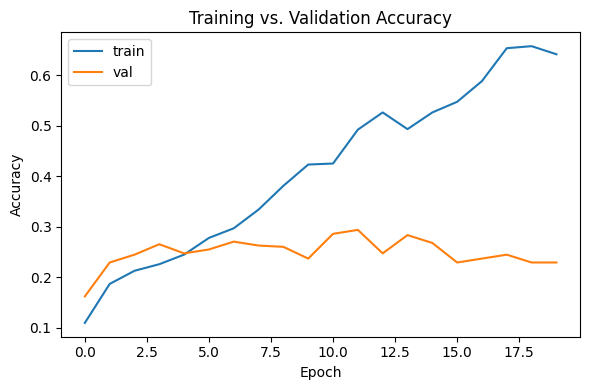

Final validation accuracy: 0.2294

Testing: hidden_layer_sizes=[1024, 512], activation=relu, optimizer=Adam, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.1445 - loss: 2.2837 - val_accuracy: 0.1933 - val_loss: 2.1496
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.2272 - loss: 2.1238 - val_accuracy: 0.2010 - val_loss: 2.0753
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.2480 - loss: 2.0637 - val_accuracy: 0.2242 - val_loss: 2.0229
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.2698 - loss: 1.9879 - val_accuracy: 0.2474 - val_loss: 1.9902
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.3158 - loss: 1.9205 - val_accuracy: 0.2474 - val_loss: 1.9948
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.3205 - loss: 1.8806 - val_accuracy: 0.2320 - val_loss: 1.9831
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━

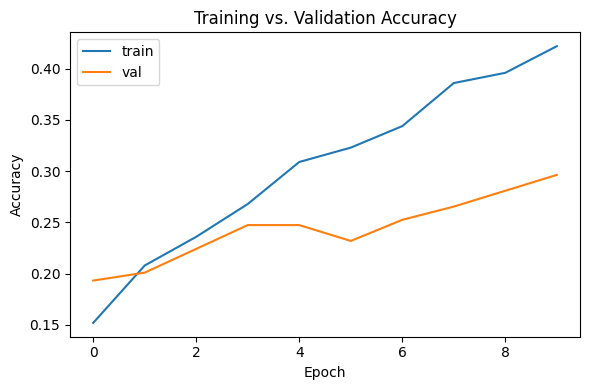

Final validation accuracy: 0.2964

Testing: hidden_layer_sizes=[1024, 512], activation=relu, optimizer=Adam, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.1449 - loss: 2.2901 - val_accuracy: 0.1907 - val_loss: 2.1670
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.2246 - loss: 2.1441 - val_accuracy: 0.2216 - val_loss: 2.0587
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.2434 - loss: 2.0690 - val_accuracy: 0.2706 - val_loss: 1.9902
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.2360 - loss: 1.9890 - val_accuracy: 0.2912 - val_loss: 1.9920
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.2856 - loss: 1.9297 - val_accuracy: 0.2577 - val_loss: 1.9943
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.3059 - loss: 1.8929 - val_accuracy: 0.2784 - val_loss: 1.9757
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━

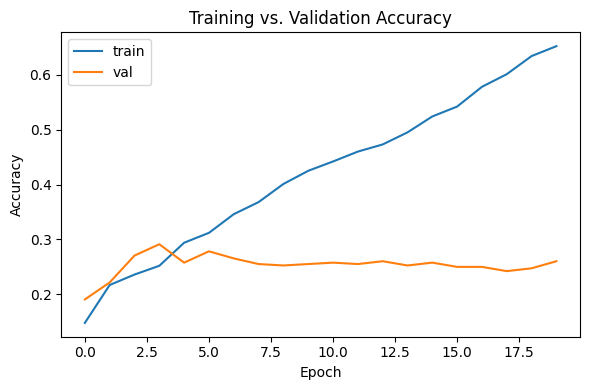

Final validation accuracy: 0.2603

Testing: hidden_layer_sizes=[1024, 512], activation=relu, optimizer=SGD, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.0856 - loss: 2.3102 - val_accuracy: 0.0954 - val_loss: 2.3051
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.0908 - loss: 2.3065 - val_accuracy: 0.1031 - val_loss: 2.3020
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.0940 - loss: 2.3031 - val_accuracy: 0.1057 - val_loss: 2.2992
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.1173 - loss: 2.2999 - val_accuracy: 0.1289 - val_loss: 2.2966
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.1175 - loss: 2.2970 - val_accuracy: 0.1186 - val_loss: 2.2941
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.1256 - loss: 2.2942 - val_accuracy: 0.1263 - val_loss: 2.2917
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 

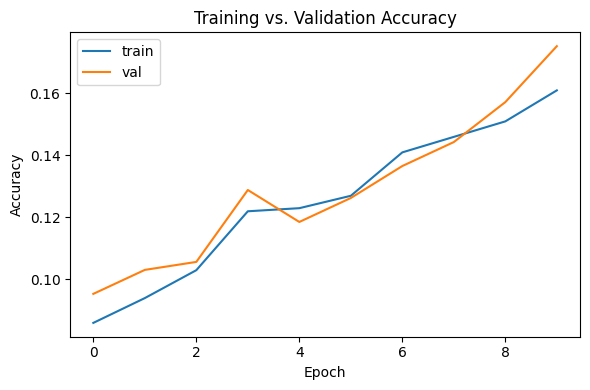

Final validation accuracy: 0.1753

Testing: hidden_layer_sizes=[1024, 512], activation=relu, optimizer=SGD, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.0926 - loss: 2.3045 - val_accuracy: 0.0954 - val_loss: 2.2950
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0910 - loss: 2.3018 - val_accuracy: 0.0979 - val_loss: 2.2934
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1055 - loss: 2.2993 - val_accuracy: 0.1057 - val_loss: 2.2919
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1197 - loss: 2.2969 - val_accuracy: 0.1186 - val_loss: 2.2904
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1489 - loss: 2.2945 - val_accuracy: 0.1263 - val_loss: 2.2889
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.1541 - loss: 2.2922 - val_accuracy: 0.1469 - val_loss: 2.2874
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 

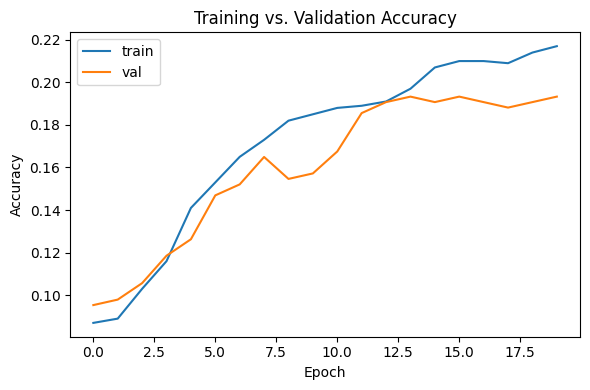

Final validation accuracy: 0.1933

Testing: hidden_layer_sizes=[1024, 512], activation=relu, optimizer=SGD, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.1007 - loss: 2.3050 - val_accuracy: 0.0876 - val_loss: 2.3061
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1010 - loss: 2.3046 - val_accuracy: 0.0851 - val_loss: 2.3058
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1003 - loss: 2.3042 - val_accuracy: 0.0825 - val_loss: 2.3054
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1010 - loss: 2.3039 - val_accuracy: 0.0825 - val_loss: 2.3051
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1009 - loss: 2.3035 - val_accuracy: 0.0902 - val_loss: 2.3047
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1005 - loss: 2.3031 - val_accuracy: 0.0851 - val_loss: 2.3044
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

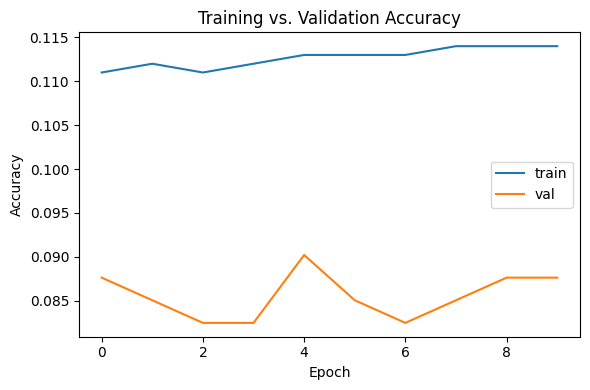

Final validation accuracy: 0.0876

Testing: hidden_layer_sizes=[1024, 512], activation=relu, optimizer=SGD, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.1246 - loss: 2.3077 - val_accuracy: 0.1057 - val_loss: 2.2969
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1258 - loss: 2.3073 - val_accuracy: 0.1082 - val_loss: 2.2967
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1243 - loss: 2.3069 - val_accuracy: 0.1108 - val_loss: 2.2965
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1229 - loss: 2.3066 - val_accuracy: 0.1108 - val_loss: 2.2963
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1222 - loss: 2.3062 - val_accuracy: 0.1108 - val_loss: 2.2961
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1222 - loss: 2.3058 - val_accuracy: 0.1134 - val_loss: 2.2959
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

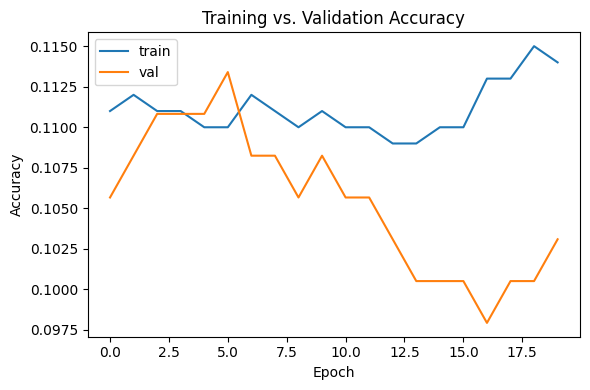

Final validation accuracy: 0.1031

Testing: hidden_layer_sizes=[1024, 512], activation=tanh, optimizer=Adam, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.1033 - loss: 2.3799 - val_accuracy: 0.1314 - val_loss: 2.2201
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.2045 - loss: 2.1883 - val_accuracy: 0.1675 - val_loss: 2.1811
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.1704 - loss: 2.1523 - val_accuracy: 0.1649 - val_loss: 2.1439
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.1871 - loss: 2.1278 - val_accuracy: 0.1495 - val_loss: 2.1638
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.1614 - loss: 2.1212 - val_accuracy: 0.1495 - val_loss: 2.1471
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.1795 - loss: 2.1076 - val_accuracy: 0.1598 - val_loss: 2.1354
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s

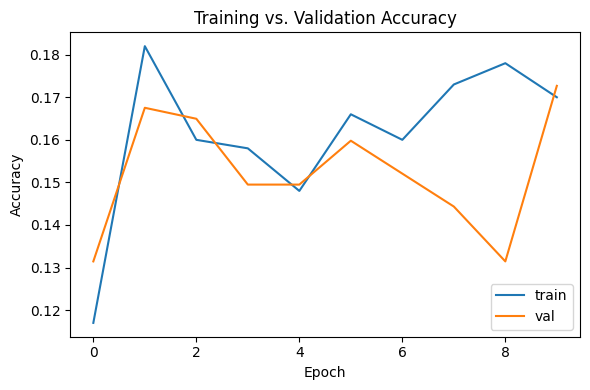

Final validation accuracy: 0.1727

Testing: hidden_layer_sizes=[1024, 512], activation=tanh, optimizer=Adam, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.1023 - loss: 2.3584 - val_accuracy: 0.1907 - val_loss: 2.2074
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.1684 - loss: 2.1731 - val_accuracy: 0.2062 - val_loss: 2.1484
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.1712 - loss: 2.1323 - val_accuracy: 0.1727 - val_loss: 2.1710
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.1921 - loss: 2.1359 - val_accuracy: 0.1572 - val_loss: 2.1801
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.1770 - loss: 2.1147 - val_accuracy: 0.1598 - val_loss: 2.1418
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.1898 - loss: 2.0872 - val_accuracy: 0.1443 - val_loss: 2.1789
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s

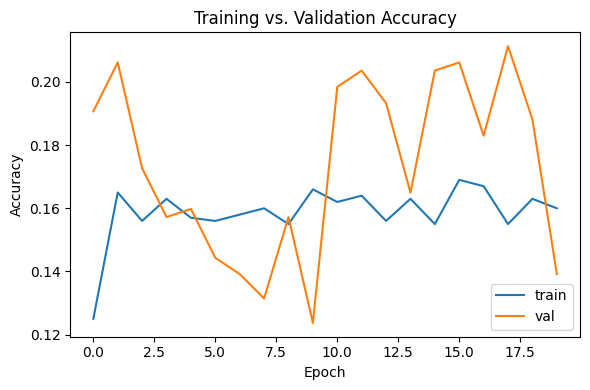

Final validation accuracy: 0.1392

Testing: hidden_layer_sizes=[1024, 512], activation=tanh, optimizer=Adam, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.1255 - loss: 2.3223 - val_accuracy: 0.1314 - val_loss: 2.2080
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.1979 - loss: 2.1502 - val_accuracy: 0.2448 - val_loss: 2.0607
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.2709 - loss: 2.0372 - val_accuracy: 0.2371 - val_loss: 2.0120
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.2879 - loss: 1.9744 - val_accuracy: 0.2268 - val_loss: 2.0002
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.3187 - loss: 1.9170 - val_accuracy: 0.2706 - val_loss: 1.9742
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.3508 - loss: 1.8532 - val_accuracy: 0.2758 - val_loss: 1.9580
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1

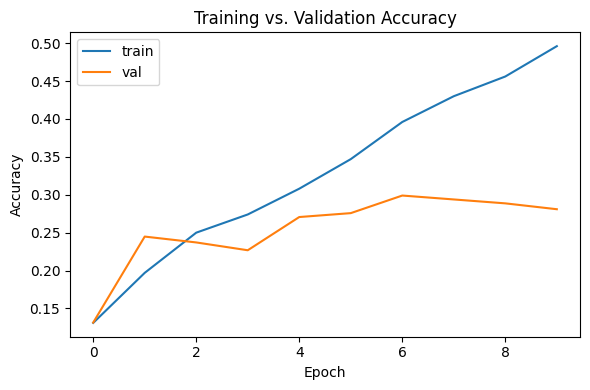

Final validation accuracy: 0.2809

Testing: hidden_layer_sizes=[1024, 512], activation=tanh, optimizer=Adam, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.1333 - loss: 2.3231 - val_accuracy: 0.1624 - val_loss: 2.1913
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.2221 - loss: 2.1404 - val_accuracy: 0.2423 - val_loss: 2.0644
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.2693 - loss: 2.0378 - val_accuracy: 0.2423 - val_loss: 2.0248
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.3061 - loss: 1.9706 - val_accuracy: 0.2294 - val_loss: 2.0053
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.3174 - loss: 1.9140 - val_accuracy: 0.2500 - val_loss: 1.9861
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.3521 - loss: 1.8556 - val_accuracy: 0.2655 - val_loss: 1.9739
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1

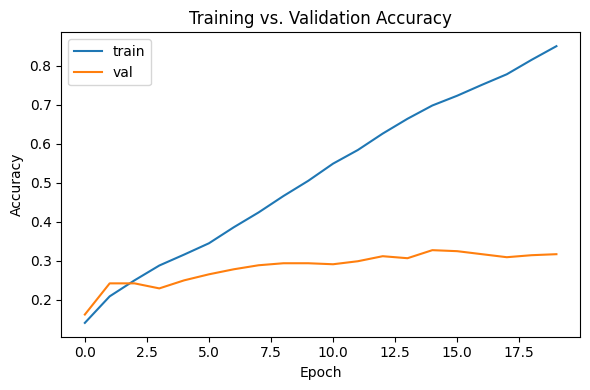

Final validation accuracy: 0.3170

Testing: hidden_layer_sizes=[1024, 512], activation=tanh, optimizer=SGD, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.1072 - loss: 2.3065 - val_accuracy: 0.1186 - val_loss: 2.3121
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1069 - loss: 2.3003 - val_accuracy: 0.1263 - val_loss: 2.3044
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1175 - loss: 2.2947 - val_accuracy: 0.1263 - val_loss: 2.2976
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1356 - loss: 2.2897 - val_accuracy: 0.1314 - val_loss: 2.2916
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1370 - loss: 2.2849 - val_accuracy: 0.1366 - val_loss: 2.2861
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1494 - loss: 2.2803 - val_accuracy: 0.1495 - val_loss: 2.2809
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 

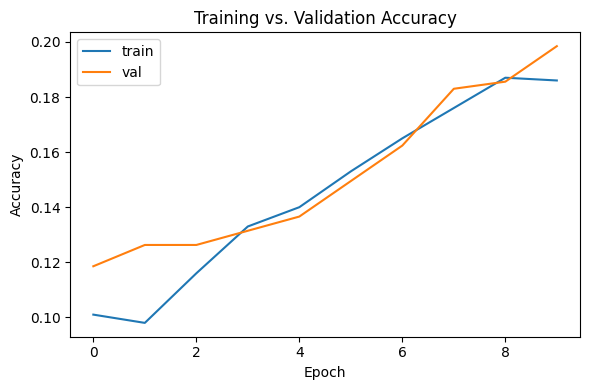

Final validation accuracy: 0.1985

Testing: hidden_layer_sizes=[1024, 512], activation=tanh, optimizer=SGD, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.0726 - loss: 2.3266 - val_accuracy: 0.0876 - val_loss: 2.3258
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0846 - loss: 2.3181 - val_accuracy: 0.0799 - val_loss: 2.3172
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0808 - loss: 2.3111 - val_accuracy: 0.0670 - val_loss: 2.3099
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0974 - loss: 2.3049 - val_accuracy: 0.0670 - val_loss: 2.3035
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1157 - loss: 2.2994 - val_accuracy: 0.0902 - val_loss: 2.2977
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1266 - loss: 2.2943 - val_accuracy: 0.1160 - val_loss: 2.2924
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 

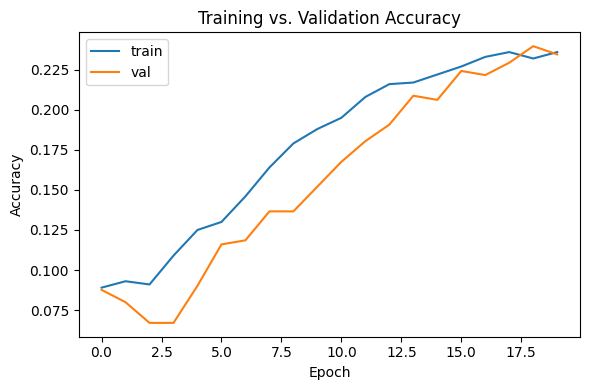

Final validation accuracy: 0.2345

Testing: hidden_layer_sizes=[1024, 512], activation=tanh, optimizer=SGD, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.1241 - loss: 2.3066 - val_accuracy: 0.0747 - val_loss: 2.3272
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1234 - loss: 2.3059 - val_accuracy: 0.0773 - val_loss: 2.3260
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1279 - loss: 2.3052 - val_accuracy: 0.0747 - val_loss: 2.3249
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1279 - loss: 2.3045 - val_accuracy: 0.0747 - val_loss: 2.3238
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1279 - loss: 2.3039 - val_accuracy: 0.0747 - val_loss: 2.3227
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1280 - loss: 2.3032 - val_accuracy: 0.0747 - val_loss: 2.3216
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

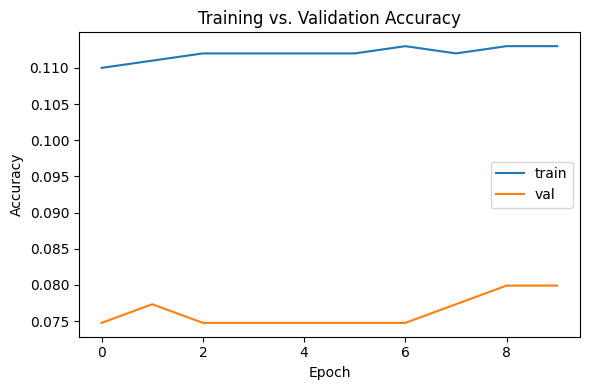

Final validation accuracy: 0.0799

Testing: hidden_layer_sizes=[1024, 512], activation=tanh, optimizer=SGD, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.1073 - loss: 2.3067 - val_accuracy: 0.1495 - val_loss: 2.2998
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1069 - loss: 2.3062 - val_accuracy: 0.1521 - val_loss: 2.2994
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1067 - loss: 2.3057 - val_accuracy: 0.1521 - val_loss: 2.2989
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1058 - loss: 2.3052 - val_accuracy: 0.1546 - val_loss: 2.2985
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1078 - loss: 2.3047 - val_accuracy: 0.1572 - val_loss: 2.2981
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1060 - loss: 2.3042 - val_accuracy: 0.1572 - val_loss: 2.2977
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

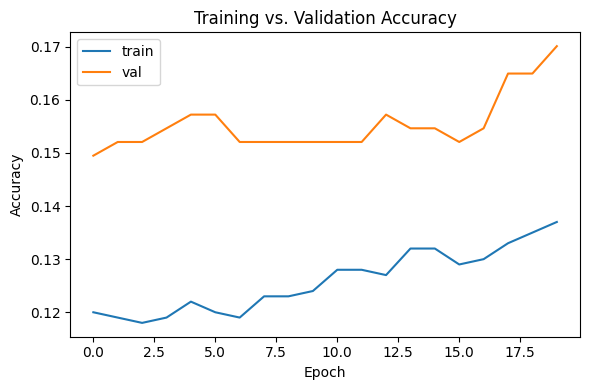

Final validation accuracy: 0.1701

Testing: hidden_layer_sizes=[512, 256], activation=relu, optimizer=Adam, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.1048 - loss: 2.4584 - val_accuracy: 0.1237 - val_loss: 2.2316
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.1651 - loss: 2.1543 - val_accuracy: 0.2036 - val_loss: 2.1216
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.1961 - loss: 2.0865 - val_accuracy: 0.2320 - val_loss: 2.0264
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2006 - loss: 2.0399 - val_accuracy: 0.2191 - val_loss: 2.0242
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2689 - loss: 1.9708 - val_accuracy: 0.2423 - val_loss: 1.9821
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3077 - loss: 1.9051 - val_accuracy: 0.2474 - val_loss: 2.0123
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 

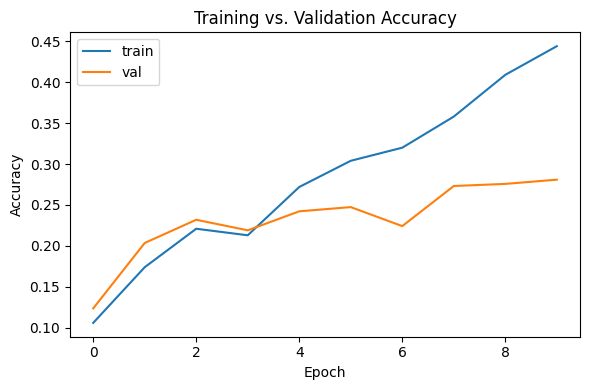

Final validation accuracy: 0.2809

Testing: hidden_layer_sizes=[512, 256], activation=relu, optimizer=Adam, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.1106 - loss: 2.4959 - val_accuracy: 0.1443 - val_loss: 2.1642
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.1837 - loss: 2.1421 - val_accuracy: 0.1907 - val_loss: 2.0672
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.2356 - loss: 2.0455 - val_accuracy: 0.2294 - val_loss: 2.0639
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.2478 - loss: 2.0027 - val_accuracy: 0.2629 - val_loss: 2.0030
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.2988 - loss: 1.9309 - val_accuracy: 0.2680 - val_loss: 1.9968
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3378 - loss: 1.8740 - val_accuracy: 0.2938 - val_loss: 1.9866
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 

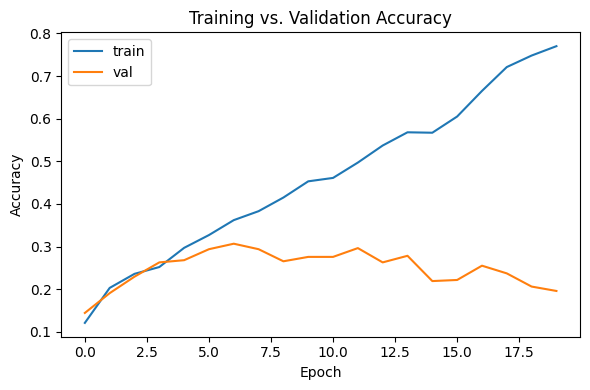

Final validation accuracy: 0.1959

Testing: hidden_layer_sizes=[512, 256], activation=relu, optimizer=Adam, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.1237 - loss: 2.2941 - val_accuracy: 0.1701 - val_loss: 2.2149
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.2136 - loss: 2.1991 - val_accuracy: 0.1804 - val_loss: 2.1106
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2396 - loss: 2.0987 - val_accuracy: 0.2371 - val_loss: 2.0366
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.2659 - loss: 2.0303 - val_accuracy: 0.2526 - val_loss: 1.9947
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2930 - loss: 1.9894 - val_accuracy: 0.2526 - val_loss: 1.9827
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3021 - loss: 1.9548 - val_accuracy: 0.2655 - val_loss: 1.9743
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s

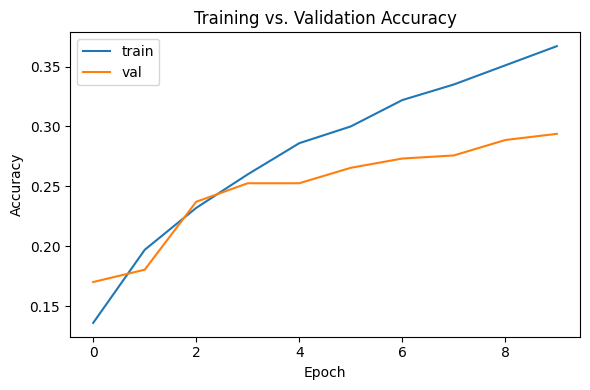

Final validation accuracy: 0.2938

Testing: hidden_layer_sizes=[512, 256], activation=relu, optimizer=Adam, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.1218 - loss: 2.2965 - val_accuracy: 0.1753 - val_loss: 2.2261
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.1997 - loss: 2.2011 - val_accuracy: 0.1778 - val_loss: 2.1181
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2257 - loss: 2.1051 - val_accuracy: 0.2165 - val_loss: 2.0425
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2449 - loss: 2.0375 - val_accuracy: 0.2242 - val_loss: 2.0134
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2823 - loss: 1.9968 - val_accuracy: 0.2732 - val_loss: 1.9909
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2926 - loss: 1.9617 - val_accuracy: 0.2732 - val_loss: 1.9759
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s

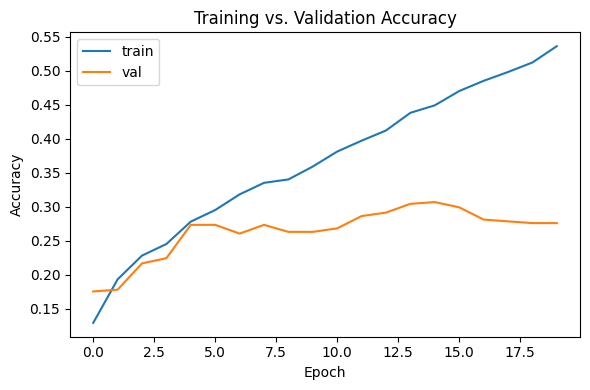

Final validation accuracy: 0.2758

Testing: hidden_layer_sizes=[512, 256], activation=relu, optimizer=SGD, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0964 - loss: 2.3052 - val_accuracy: 0.0979 - val_loss: 2.3032
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0972 - loss: 2.3037 - val_accuracy: 0.0979 - val_loss: 2.3018
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1029 - loss: 2.3022 - val_accuracy: 0.1005 - val_loss: 2.3004
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1038 - loss: 2.3007 - val_accuracy: 0.1005 - val_loss: 2.2990
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1088 - loss: 2.2993 - val_accuracy: 0.1057 - val_loss: 2.2977
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1163 - loss: 2.2979 - val_accuracy: 0.1160 - val_loss: 2.2964
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1

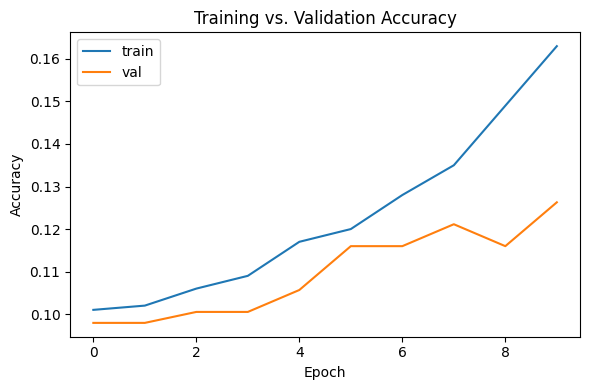

Final validation accuracy: 0.1263

Testing: hidden_layer_sizes=[512, 256], activation=relu, optimizer=SGD, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1067 - loss: 2.3051 - val_accuracy: 0.0979 - val_loss: 2.3090
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1084 - loss: 2.3036 - val_accuracy: 0.0979 - val_loss: 2.3073
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1122 - loss: 2.3022 - val_accuracy: 0.1005 - val_loss: 2.3057
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1191 - loss: 2.3008 - val_accuracy: 0.1057 - val_loss: 2.3041
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1249 - loss: 2.2994 - val_accuracy: 0.1237 - val_loss: 2.3026
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1347 - loss: 2.2981 - val_accuracy: 0.1289 - val_loss: 2.3010
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1

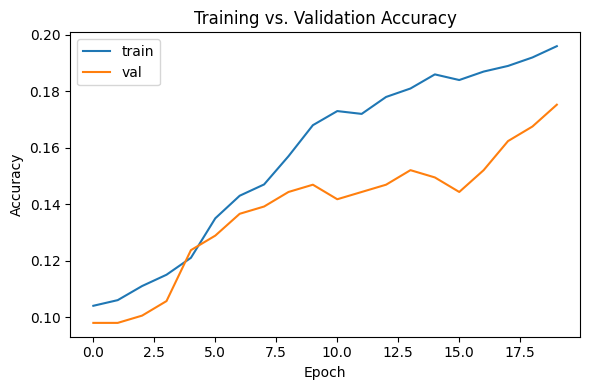

Final validation accuracy: 0.1753

Testing: hidden_layer_sizes=[512, 256], activation=relu, optimizer=SGD, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0882 - loss: 2.3097 - val_accuracy: 0.0851 - val_loss: 2.2934
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0882 - loss: 2.3095 - val_accuracy: 0.0851 - val_loss: 2.2933
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0890 - loss: 2.3093 - val_accuracy: 0.0851 - val_loss: 2.2932
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0890 - loss: 2.3091 - val_accuracy: 0.0851 - val_loss: 2.2931
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0890 - loss: 2.3089 - val_accuracy: 0.0851 - val_loss: 2.2930
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0890 - loss: 2.3087 - val_accuracy: 0.0851 - val_loss: 2.2930
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 

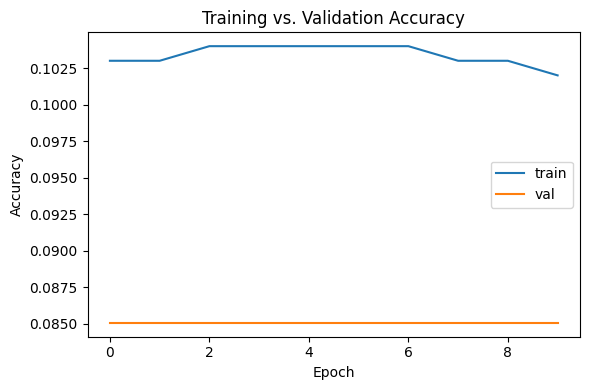

Final validation accuracy: 0.0851

Testing: hidden_layer_sizes=[512, 256], activation=relu, optimizer=SGD, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1075 - loss: 2.3035 - val_accuracy: 0.1418 - val_loss: 2.3040
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1082 - loss: 2.3033 - val_accuracy: 0.1443 - val_loss: 2.3039
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1082 - loss: 2.3031 - val_accuracy: 0.1469 - val_loss: 2.3037
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1086 - loss: 2.3029 - val_accuracy: 0.1495 - val_loss: 2.3035
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1089 - loss: 2.3028 - val_accuracy: 0.1495 - val_loss: 2.3033
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1111 - loss: 2.3026 - val_accuracy: 0.1495 - val_loss: 2.3032
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 

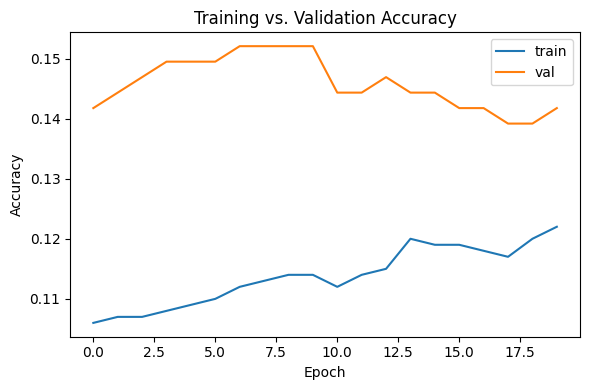

Final validation accuracy: 0.1418

Testing: hidden_layer_sizes=[512, 256], activation=tanh, optimizer=Adam, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.0845 - loss: 2.3085 - val_accuracy: 0.2191 - val_loss: 2.1821
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.1762 - loss: 2.1573 - val_accuracy: 0.2062 - val_loss: 2.1026
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.1785 - loss: 2.0929 - val_accuracy: 0.1701 - val_loss: 2.1426
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2062 - loss: 2.0740 - val_accuracy: 0.1624 - val_loss: 2.1540
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2132 - loss: 2.0786 - val_accuracy: 0.1624 - val_loss: 2.1409
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.1996 - loss: 2.0603 - val_accuracy: 0.1985 - val_loss: 2.1585
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 

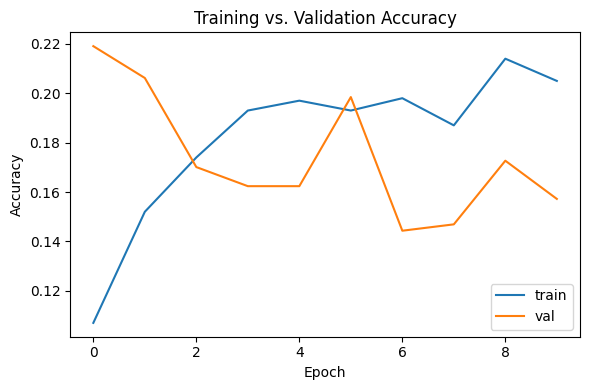

Final validation accuracy: 0.1572

Testing: hidden_layer_sizes=[512, 256], activation=tanh, optimizer=Adam, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.1203 - loss: 2.3009 - val_accuracy: 0.1572 - val_loss: 2.1771
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.1891 - loss: 2.1397 - val_accuracy: 0.1701 - val_loss: 2.1449
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2015 - loss: 2.0870 - val_accuracy: 0.2191 - val_loss: 2.0957
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.1778 - loss: 2.0453 - val_accuracy: 0.1985 - val_loss: 2.1473
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.1847 - loss: 2.0722 - val_accuracy: 0.1392 - val_loss: 2.1593
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.1856 - loss: 2.0747 - val_accuracy: 0.2268 - val_loss: 2.1319
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 

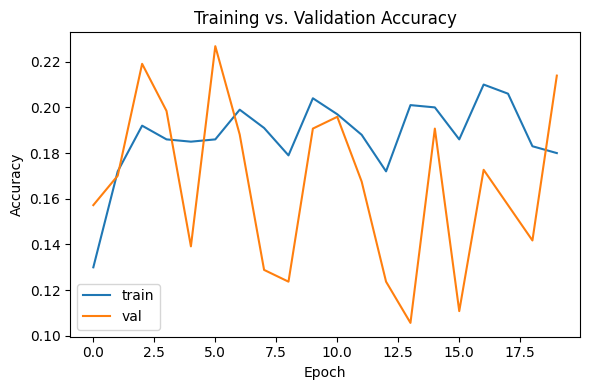

Final validation accuracy: 0.2139

Testing: hidden_layer_sizes=[512, 256], activation=tanh, optimizer=Adam, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.1155 - loss: 2.3033 - val_accuracy: 0.1985 - val_loss: 2.2121
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.2314 - loss: 2.1872 - val_accuracy: 0.2320 - val_loss: 2.1354
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.2676 - loss: 2.1009 - val_accuracy: 0.2732 - val_loss: 2.0765
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.2941 - loss: 2.0424 - val_accuracy: 0.2706 - val_loss: 2.0387
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3096 - loss: 1.9944 - val_accuracy: 0.2938 - val_loss: 2.0164
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3605 - loss: 1.9483 - val_accuracy: 0.2912 - val_loss: 2.0014
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s

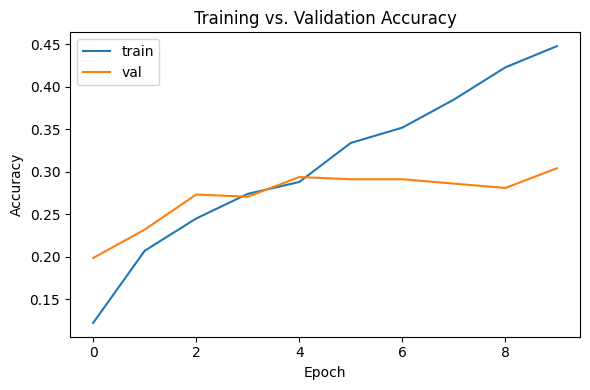

Final validation accuracy: 0.3041

Testing: hidden_layer_sizes=[512, 256], activation=tanh, optimizer=Adam, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.1242 - loss: 2.3013 - val_accuracy: 0.1778 - val_loss: 2.2258
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.2425 - loss: 2.1895 - val_accuracy: 0.1830 - val_loss: 2.1323
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2677 - loss: 2.0940 - val_accuracy: 0.1881 - val_loss: 2.0813
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.2789 - loss: 2.0384 - val_accuracy: 0.2294 - val_loss: 2.0421
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3019 - loss: 1.9887 - val_accuracy: 0.2706 - val_loss: 2.0113
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3302 - loss: 1.9433 - val_accuracy: 0.2861 - val_loss: 1.9969
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s

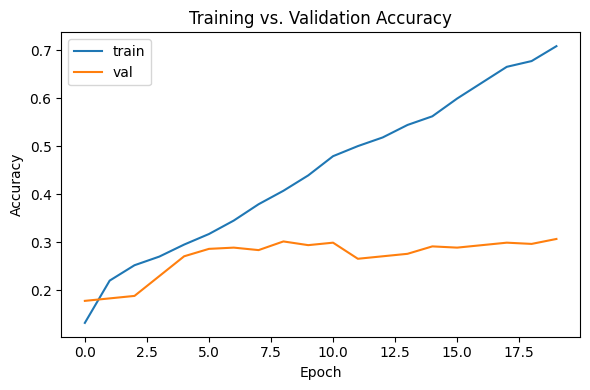

Final validation accuracy: 0.3067

Testing: hidden_layer_sizes=[512, 256], activation=tanh, optimizer=SGD, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.0945 - loss: 2.3028 - val_accuracy: 0.0876 - val_loss: 2.3047
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0932 - loss: 2.3006 - val_accuracy: 0.0954 - val_loss: 2.3025
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1110 - loss: 2.2985 - val_accuracy: 0.1005 - val_loss: 2.3004
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1185 - loss: 2.2965 - val_accuracy: 0.1082 - val_loss: 2.2984
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1253 - loss: 2.2944 - val_accuracy: 0.1186 - val_loss: 2.2965
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1349 - loss: 2.2925 - val_accuracy: 0.1237 - val_loss: 2.2945
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2

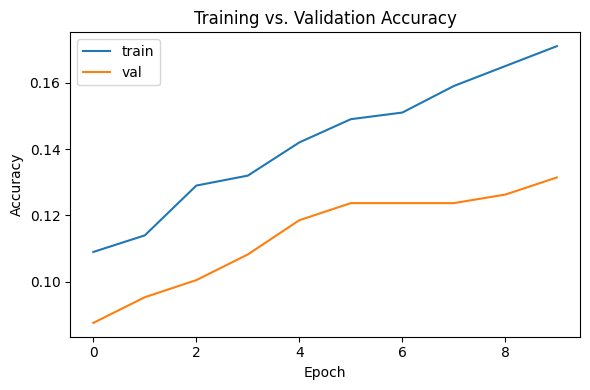

Final validation accuracy: 0.1314

Testing: hidden_layer_sizes=[512, 256], activation=tanh, optimizer=SGD, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1299 - loss: 2.3059 - val_accuracy: 0.1546 - val_loss: 2.3028
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1407 - loss: 2.3033 - val_accuracy: 0.1649 - val_loss: 2.3004
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1456 - loss: 2.3008 - val_accuracy: 0.1753 - val_loss: 2.2982
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1528 - loss: 2.2984 - val_accuracy: 0.1856 - val_loss: 2.2960
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1548 - loss: 2.2961 - val_accuracy: 0.1907 - val_loss: 2.2939
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1647 - loss: 2.2938 - val_accuracy: 0.1881 - val_loss: 2.2917
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2

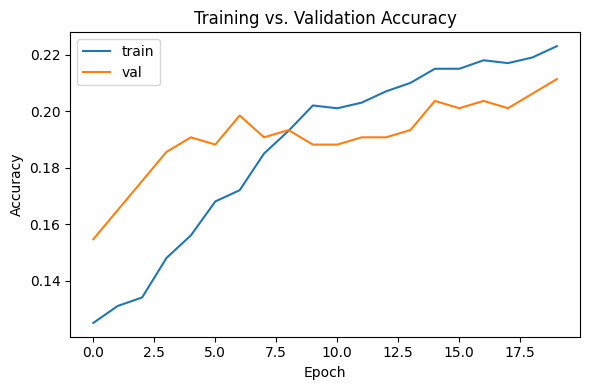

Final validation accuracy: 0.2113

Testing: hidden_layer_sizes=[512, 256], activation=tanh, optimizer=SGD, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1050 - loss: 2.3079 - val_accuracy: 0.0851 - val_loss: 2.3209
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1071 - loss: 2.3076 - val_accuracy: 0.0851 - val_loss: 2.3205
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1086 - loss: 2.3073 - val_accuracy: 0.0902 - val_loss: 2.3200
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1080 - loss: 2.3070 - val_accuracy: 0.0902 - val_loss: 2.3196
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1085 - loss: 2.3067 - val_accuracy: 0.0902 - val_loss: 2.3191
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1085 - loss: 2.3065 - val_accuracy: 0.0902 - val_loss: 2.3187
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 

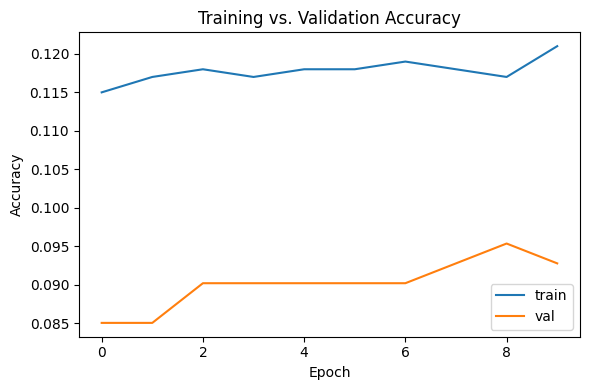

Final validation accuracy: 0.0928

Testing: hidden_layer_sizes=[512, 256], activation=tanh, optimizer=SGD, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1112 - loss: 2.3013 - val_accuracy: 0.0799 - val_loss: 2.3076
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1115 - loss: 2.3010 - val_accuracy: 0.0799 - val_loss: 2.3073
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1120 - loss: 2.3007 - val_accuracy: 0.0799 - val_loss: 2.3069
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1120 - loss: 2.3005 - val_accuracy: 0.0799 - val_loss: 2.3066
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1152 - loss: 2.3002 - val_accuracy: 0.0799 - val_loss: 2.3062
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1170 - loss: 2.2999 - val_accuracy: 0.0799 - val_loss: 2.3059
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 

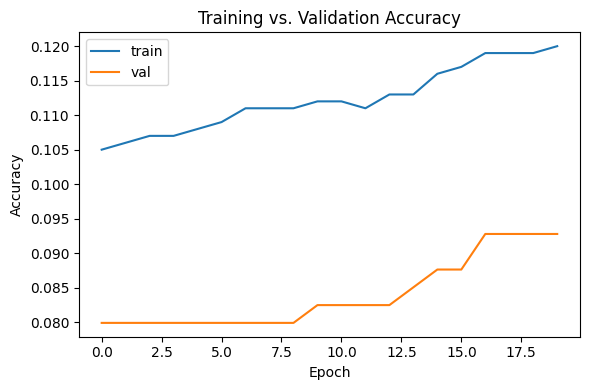

Final validation accuracy: 0.0928

Testing: hidden_layer_sizes=[256], activation=relu, optimizer=Adam, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0923 - loss: 2.5128 - val_accuracy: 0.1804 - val_loss: 2.1708
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1977 - loss: 2.1367 - val_accuracy: 0.2732 - val_loss: 2.0214
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2057 - loss: 2.0652 - val_accuracy: 0.2448 - val_loss: 2.0344
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2290 - loss: 2.0044 - val_accuracy: 0.2165 - val_loss: 2.0325
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2945 - loss: 1.9424 - val_accuracy: 0.2526 - val_loss: 2.0176
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3066 - loss: 1.8883 - val_accuracy: 0.2500 - val_loss: 2.0046
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/

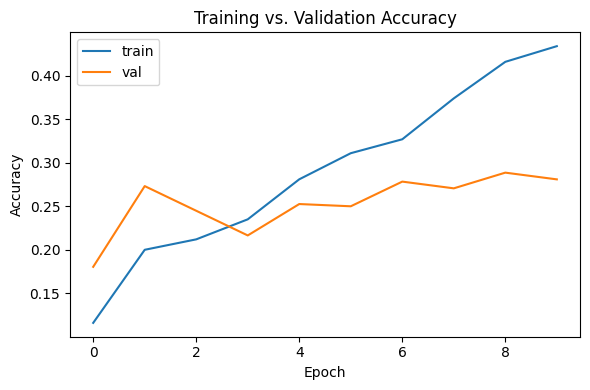

Final validation accuracy: 0.2809

Testing: hidden_layer_sizes=[256], activation=relu, optimizer=Adam, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.1270 - loss: 2.4535 - val_accuracy: 0.2062 - val_loss: 2.1461
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2304 - loss: 2.1136 - val_accuracy: 0.1907 - val_loss: 2.0785
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2474 - loss: 2.0536 - val_accuracy: 0.2423 - val_loss: 2.0289
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2672 - loss: 1.9904 - val_accuracy: 0.2629 - val_loss: 1.9831
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2921 - loss: 1.9327 - val_accuracy: 0.2423 - val_loss: 2.0006
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3192 - loss: 1.8656 - val_accuracy: 0.2732 - val_loss: 1.9765
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/

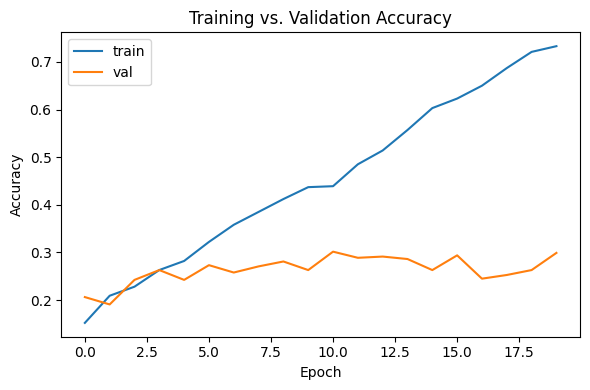

Final validation accuracy: 0.2990

Testing: hidden_layer_sizes=[256], activation=relu, optimizer=Adam, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1201 - loss: 2.3088 - val_accuracy: 0.1546 - val_loss: 2.2731
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2116 - loss: 2.2327 - val_accuracy: 0.2706 - val_loss: 2.1600
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2957 - loss: 2.1426 - val_accuracy: 0.2062 - val_loss: 2.1102
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2983 - loss: 2.0780 - val_accuracy: 0.2216 - val_loss: 2.0668
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3103 - loss: 2.0267 - val_accuracy: 0.2577 - val_loss: 2.0328
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3191 - loss: 1.9848 - val_accuracy: 0.2655 - val_loss: 2.0173
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms

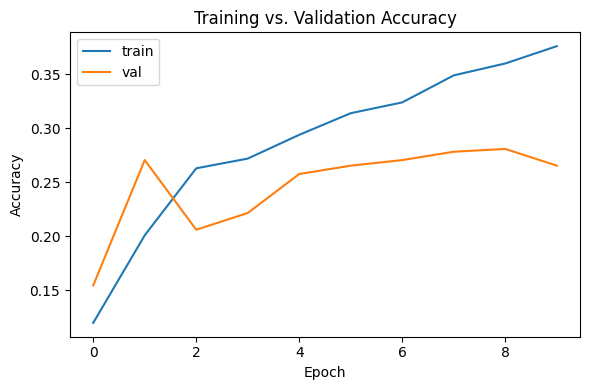

Final validation accuracy: 0.2655

Testing: hidden_layer_sizes=[256], activation=relu, optimizer=Adam, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.1580 - loss: 2.2927 - val_accuracy: 0.1031 - val_loss: 2.2396
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1684 - loss: 2.2107 - val_accuracy: 0.1856 - val_loss: 2.1455
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2696 - loss: 2.1080 - val_accuracy: 0.2371 - val_loss: 2.0794
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2973 - loss: 2.0472 - val_accuracy: 0.2320 - val_loss: 2.0531
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3033 - loss: 2.0018 - val_accuracy: 0.2216 - val_loss: 2.0366
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3186 - loss: 1.9668 - val_accuracy: 0.2423 - val_loss: 2.0220
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms

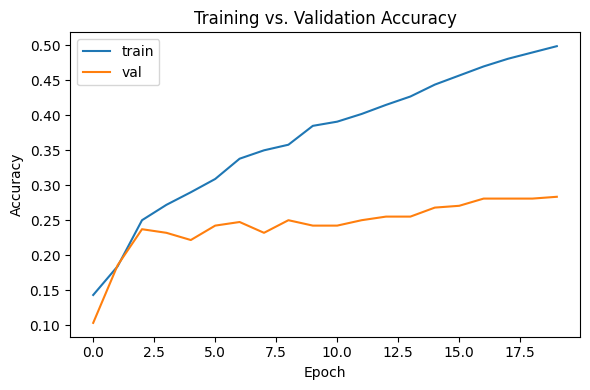

Final validation accuracy: 0.2835

Testing: hidden_layer_sizes=[256], activation=relu, optimizer=SGD, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0848 - loss: 2.3138 - val_accuracy: 0.0825 - val_loss: 2.2983
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0883 - loss: 2.3104 - val_accuracy: 0.0851 - val_loss: 2.2965
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0821 - loss: 2.3073 - val_accuracy: 0.0876 - val_loss: 2.2948
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0846 - loss: 2.3045 - val_accuracy: 0.0979 - val_loss: 2.2932
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1041 - loss: 2.3019 - val_accuracy: 0.1005 - val_loss: 2.2916
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1082 - loss: 2.2995 - val_accuracy: 0.1031 - val_loss: 2.2900
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/s

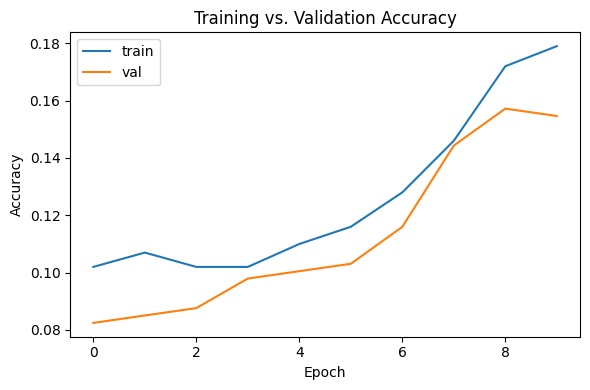

Final validation accuracy: 0.1546

Testing: hidden_layer_sizes=[256], activation=relu, optimizer=SGD, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0900 - loss: 2.3050 - val_accuracy: 0.0928 - val_loss: 2.3008
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0979 - loss: 2.3023 - val_accuracy: 0.1005 - val_loss: 2.2990
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1013 - loss: 2.2998 - val_accuracy: 0.1057 - val_loss: 2.2973
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1080 - loss: 2.2974 - val_accuracy: 0.1211 - val_loss: 2.2957
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1284 - loss: 2.2952 - val_accuracy: 0.1314 - val_loss: 2.2940
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1392 - loss: 2.2929 - val_accuracy: 0.1521 - val_loss: 2.2923
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/s

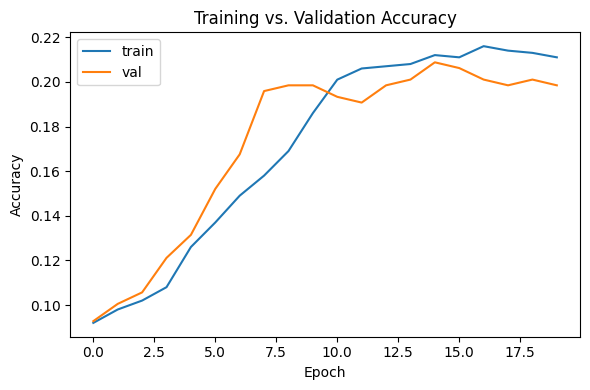

Final validation accuracy: 0.1985

Testing: hidden_layer_sizes=[256], activation=relu, optimizer=SGD, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0931 - loss: 2.3058 - val_accuracy: 0.1186 - val_loss: 2.2872
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0919 - loss: 2.3055 - val_accuracy: 0.1186 - val_loss: 2.2871
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0932 - loss: 2.3052 - val_accuracy: 0.1160 - val_loss: 2.2871
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0936 - loss: 2.3050 - val_accuracy: 0.1160 - val_loss: 2.2870
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0933 - loss: 2.3047 - val_accuracy: 0.1160 - val_loss: 2.2870
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0924 - loss: 2.3044 - val_accuracy: 0.1186 - val_loss: 2.2870
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

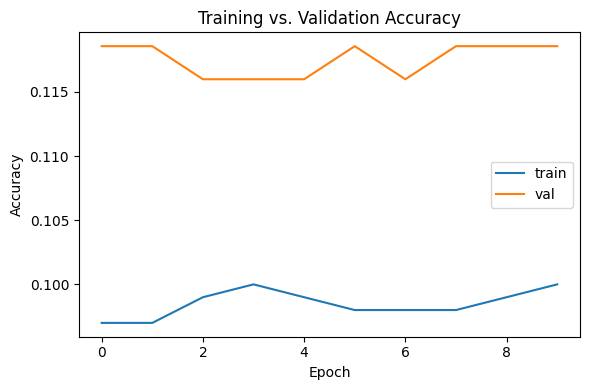

Final validation accuracy: 0.1186

Testing: hidden_layer_sizes=[256], activation=relu, optimizer=SGD, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1071 - loss: 2.3037 - val_accuracy: 0.1186 - val_loss: 2.2985
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1054 - loss: 2.3034 - val_accuracy: 0.1186 - val_loss: 2.2984
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1062 - loss: 2.3032 - val_accuracy: 0.1237 - val_loss: 2.2982
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1063 - loss: 2.3030 - val_accuracy: 0.1237 - val_loss: 2.2980
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1052 - loss: 2.3027 - val_accuracy: 0.1237 - val_loss: 2.2979
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1034 - loss: 2.3025 - val_accuracy: 0.1263 - val_loss: 2.2977
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

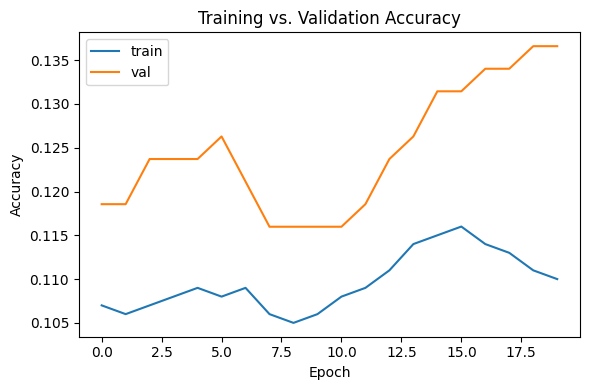

Final validation accuracy: 0.1366

Testing: hidden_layer_sizes=[256], activation=tanh, optimizer=Adam, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1081 - loss: 2.3542 - val_accuracy: 0.0979 - val_loss: 2.2527
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1346 - loss: 2.2505 - val_accuracy: 0.1598 - val_loss: 2.1649
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2003 - loss: 2.1500 - val_accuracy: 0.2216 - val_loss: 2.1234
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2130 - loss: 2.1110 - val_accuracy: 0.2268 - val_loss: 2.0907
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2418 - loss: 2.0724 - val_accuracy: 0.2655 - val_loss: 2.0817
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2395 - loss: 2.0637 - val_accuracy: 0.2191 - val_loss: 2.0848
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/

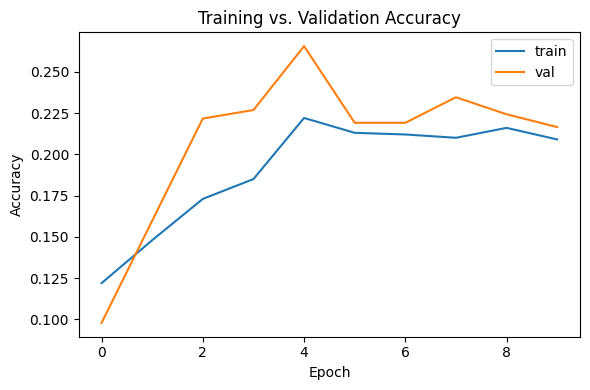

Final validation accuracy: 0.2165

Testing: hidden_layer_sizes=[256], activation=tanh, optimizer=Adam, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.1198 - loss: 2.3392 - val_accuracy: 0.1031 - val_loss: 2.2547
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1335 - loss: 2.2257 - val_accuracy: 0.1701 - val_loss: 2.1448
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2167 - loss: 2.1271 - val_accuracy: 0.2577 - val_loss: 2.1055
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1876 - loss: 2.1019 - val_accuracy: 0.2216 - val_loss: 2.0953
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1998 - loss: 2.0703 - val_accuracy: 0.1727 - val_loss: 2.0712
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2104 - loss: 2.0424 - val_accuracy: 0.2655 - val_loss: 2.0571
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/

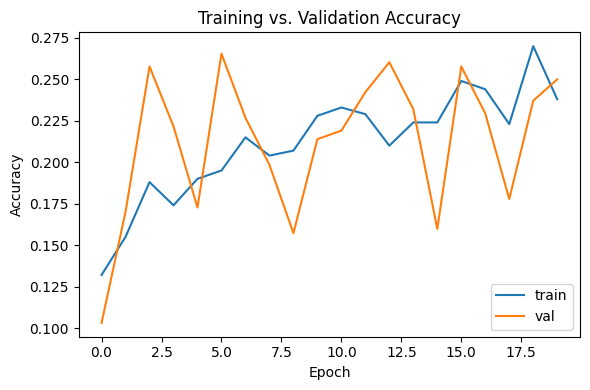

Final validation accuracy: 0.2500

Testing: hidden_layer_sizes=[256], activation=tanh, optimizer=Adam, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.1199 - loss: 2.3042 - val_accuracy: 0.1186 - val_loss: 2.2232
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1860 - loss: 2.1935 - val_accuracy: 0.2397 - val_loss: 2.1345
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2850 - loss: 2.0992 - val_accuracy: 0.2577 - val_loss: 2.0847
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2961 - loss: 2.0440 - val_accuracy: 0.2784 - val_loss: 2.0558
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3147 - loss: 2.0002 - val_accuracy: 0.2706 - val_loss: 2.0357
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3398 - loss: 1.9606 - val_accuracy: 0.2706 - val_loss: 2.0278
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms

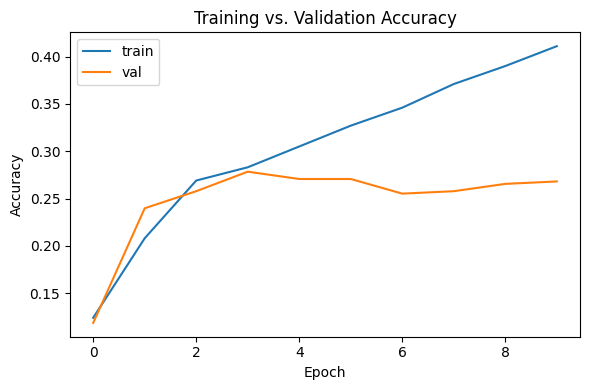

Final validation accuracy: 0.2680

Testing: hidden_layer_sizes=[256], activation=tanh, optimizer=Adam, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.1495 - loss: 2.3007 - val_accuracy: 0.1057 - val_loss: 2.2375
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1763 - loss: 2.2049 - val_accuracy: 0.2758 - val_loss: 2.1477
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3022 - loss: 2.1106 - val_accuracy: 0.2500 - val_loss: 2.0937
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3127 - loss: 2.0517 - val_accuracy: 0.2448 - val_loss: 2.0584
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3182 - loss: 2.0069 - val_accuracy: 0.2732 - val_loss: 2.0288
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3360 - loss: 1.9621 - val_accuracy: 0.2809 - val_loss: 2.0204
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms

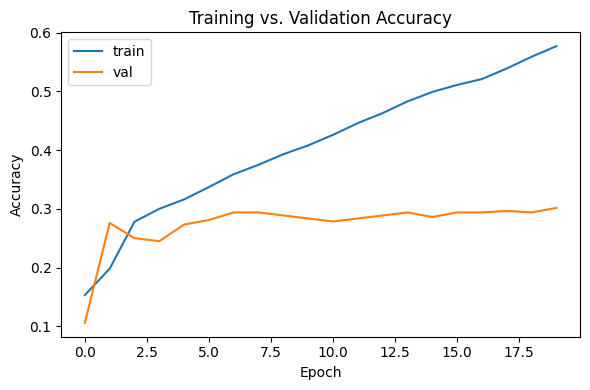

Final validation accuracy: 0.3015

Testing: hidden_layer_sizes=[256], activation=tanh, optimizer=SGD, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0953 - loss: 2.3062 - val_accuracy: 0.1314 - val_loss: 2.2969
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0938 - loss: 2.3031 - val_accuracy: 0.1314 - val_loss: 2.2944
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0974 - loss: 2.3002 - val_accuracy: 0.1211 - val_loss: 2.2921
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1098 - loss: 2.2975 - val_accuracy: 0.1392 - val_loss: 2.2898
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1264 - loss: 2.2948 - val_accuracy: 0.1469 - val_loss: 2.2875
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1361 - loss: 2.2923 - val_accuracy: 0.1572 - val_loss: 2.2853
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/s

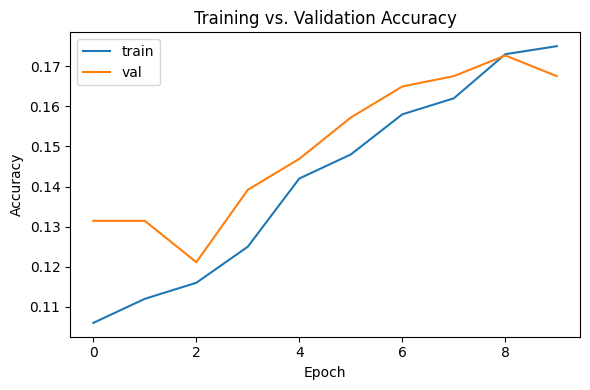

Final validation accuracy: 0.1675

Testing: hidden_layer_sizes=[256], activation=tanh, optimizer=SGD, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0977 - loss: 2.3057 - val_accuracy: 0.1211 - val_loss: 2.2959
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1003 - loss: 2.3028 - val_accuracy: 0.1418 - val_loss: 2.2939
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1045 - loss: 2.3001 - val_accuracy: 0.1469 - val_loss: 2.2919
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1132 - loss: 2.2975 - val_accuracy: 0.1469 - val_loss: 2.2899
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1274 - loss: 2.2949 - val_accuracy: 0.1598 - val_loss: 2.2880
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1470 - loss: 2.2925 - val_accuracy: 0.1546 - val_loss: 2.2860
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

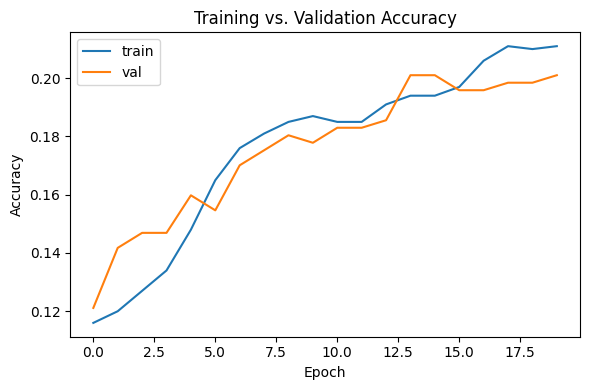

Final validation accuracy: 0.2010

Testing: hidden_layer_sizes=[256], activation=tanh, optimizer=SGD, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0784 - loss: 2.3159 - val_accuracy: 0.0747 - val_loss: 2.3076
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0848 - loss: 2.3155 - val_accuracy: 0.0747 - val_loss: 2.3072
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0860 - loss: 2.3150 - val_accuracy: 0.0747 - val_loss: 2.3069
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0888 - loss: 2.3146 - val_accuracy: 0.0747 - val_loss: 2.3065
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0856 - loss: 2.3142 - val_accuracy: 0.0747 - val_loss: 2.3061
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0848 - loss: 2.3138 - val_accuracy: 0.0747 - val_loss: 2.3058
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/

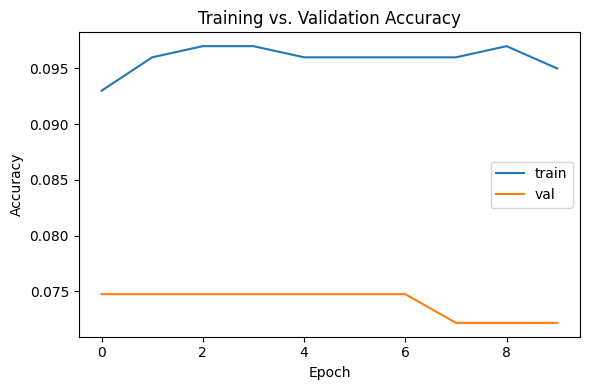

Final validation accuracy: 0.0722

Testing: hidden_layer_sizes=[256], activation=tanh, optimizer=SGD, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0791 - loss: 2.3083 - val_accuracy: 0.0567 - val_loss: 2.3040
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0786 - loss: 2.3080 - val_accuracy: 0.0541 - val_loss: 2.3037
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0793 - loss: 2.3078 - val_accuracy: 0.0515 - val_loss: 2.3035
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0776 - loss: 2.3075 - val_accuracy: 0.0515 - val_loss: 2.3032
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0773 - loss: 2.3073 - val_accuracy: 0.0515 - val_loss: 2.3030
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0773 - loss: 2.3070 - val_accuracy: 0.0541 - val_loss: 2.3028
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/

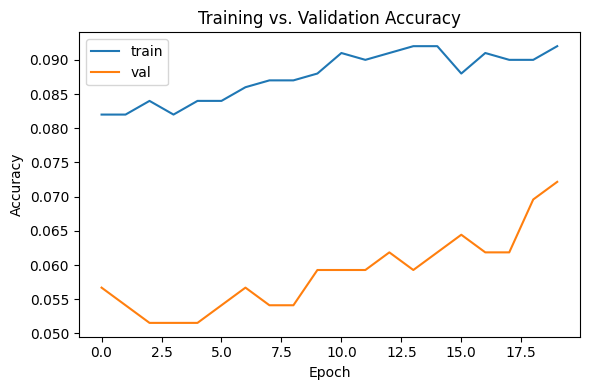

Final validation accuracy: 0.0722

Testing: hidden_layer_sizes=[], activation=relu, optimizer=Adam, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1012 - loss: 4.1626 - val_accuracy: 0.2010 - val_loss: 2.7113
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2081 - loss: 2.3383 - val_accuracy: 0.2577 - val_loss: 2.1527
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3548 - loss: 1.8566 - val_accuracy: 0.2603 - val_loss: 2.0018
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3836 - loss: 1.7294 - val_accuracy: 0.2655 - val_loss: 2.0253
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4409 - loss: 1.6402 - val_accuracy: 0.2758 - val_loss: 2.0498
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4634 - loss: 1.5910 - val_accuracy: 0.2835 - val_loss: 2.0308
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - ac

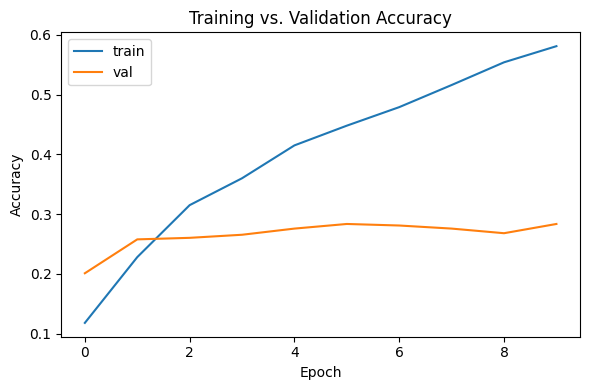

Final validation accuracy: 0.2835

Testing: hidden_layer_sizes=[], activation=relu, optimizer=Adam, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1264 - loss: 3.8320 - val_accuracy: 0.1881 - val_loss: 2.3885
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2573 - loss: 2.1707 - val_accuracy: 0.2706 - val_loss: 2.1735
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2747 - loss: 2.0396 - val_accuracy: 0.2474 - val_loss: 2.0823
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3784 - loss: 1.7785 - val_accuracy: 0.2165 - val_loss: 2.1037
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3880 - loss: 1.7173 - val_accuracy: 0.2732 - val_loss: 2.0486
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4337 - loss: 1.6342 - val_accuracy: 0.2835 - val_loss: 2.0470
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - ac

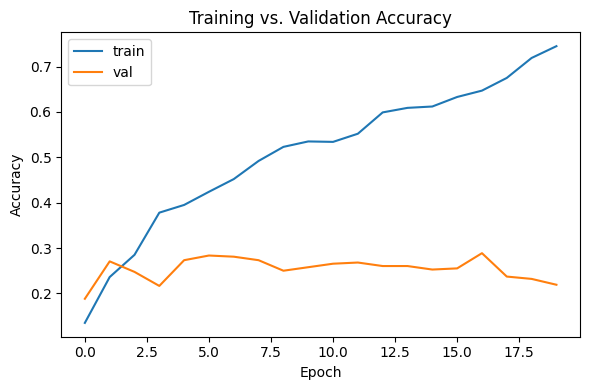

Final validation accuracy: 0.2191

Testing: hidden_layer_sizes=[], activation=relu, optimizer=Adam, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0997 - loss: 2.4079 - val_accuracy: 0.1495 - val_loss: 2.2640
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1965 - loss: 2.1818 - val_accuracy: 0.1624 - val_loss: 2.1974
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2242 - loss: 2.1180 - val_accuracy: 0.1907 - val_loss: 2.1140
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2552 - loss: 2.0322 - val_accuracy: 0.1959 - val_loss: 2.0901
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2934 - loss: 1.9832 - val_accuracy: 0.2036 - val_loss: 2.0787
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3095 - loss: 1.9473 - val_accuracy: 0.2113 - val_loss: 2.0675
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - a

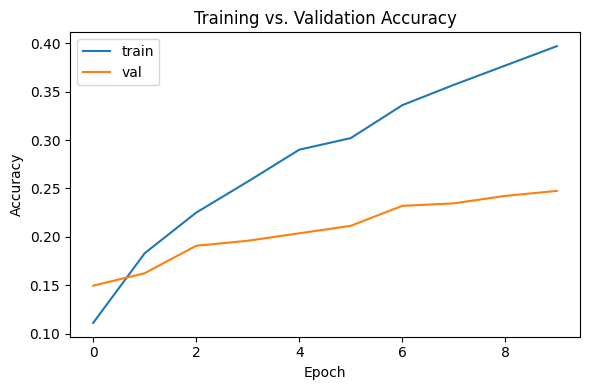

Final validation accuracy: 0.2474

Testing: hidden_layer_sizes=[], activation=relu, optimizer=Adam, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1268 - loss: 2.3657 - val_accuracy: 0.1881 - val_loss: 2.1962
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1856 - loss: 2.1962 - val_accuracy: 0.2036 - val_loss: 2.1244
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2171 - loss: 2.1096 - val_accuracy: 0.2242 - val_loss: 2.0983
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2582 - loss: 2.0259 - val_accuracy: 0.2113 - val_loss: 2.0682
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2843 - loss: 1.9823 - val_accuracy: 0.2139 - val_loss: 2.0562
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3033 - loss: 1.9450 - val_accuracy: 0.2216 - val_loss: 2.0466
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - a

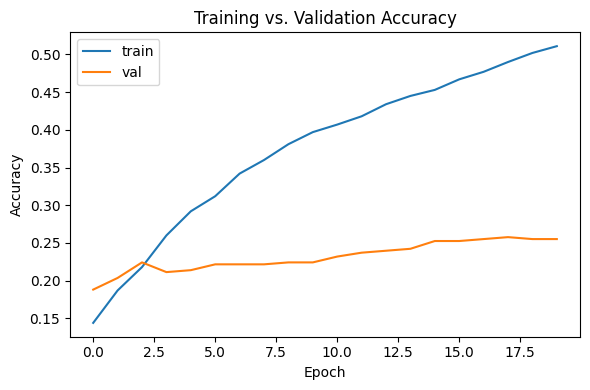

Final validation accuracy: 0.2552

Testing: hidden_layer_sizes=[], activation=relu, optimizer=SGD, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0981 - loss: 2.3690 - val_accuracy: 0.1108 - val_loss: 2.3009
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1371 - loss: 2.2788 - val_accuracy: 0.1314 - val_loss: 2.2573
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1675 - loss: 2.2353 - val_accuracy: 0.1469 - val_loss: 2.2219
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1758 - loss: 2.1990 - val_accuracy: 0.1624 - val_loss: 2.1933
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1899 - loss: 2.1682 - val_accuracy: 0.1881 - val_loss: 2.1697
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2042 - loss: 2.1414 - val_accuracy: 0.2010 - val_loss: 2.1501
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc

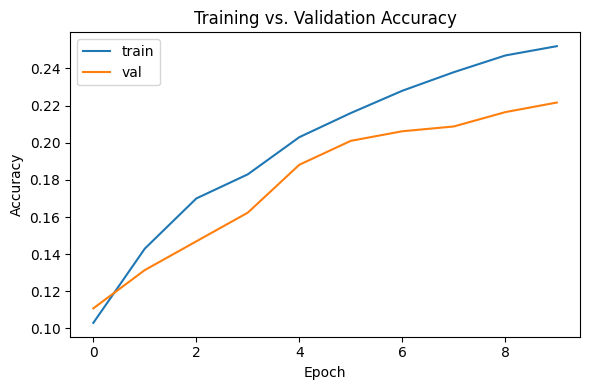

Final validation accuracy: 0.2216

Testing: hidden_layer_sizes=[], activation=relu, optimizer=SGD, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1261 - loss: 2.3268 - val_accuracy: 0.1005 - val_loss: 2.2956
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1458 - loss: 2.2622 - val_accuracy: 0.1263 - val_loss: 2.2535
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1698 - loss: 2.2202 - val_accuracy: 0.1366 - val_loss: 2.2198
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1981 - loss: 2.1849 - val_accuracy: 0.1753 - val_loss: 2.1926
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2083 - loss: 2.1547 - val_accuracy: 0.1881 - val_loss: 2.1701
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2196 - loss: 2.1284 - val_accuracy: 0.1985 - val_loss: 2.1513
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc

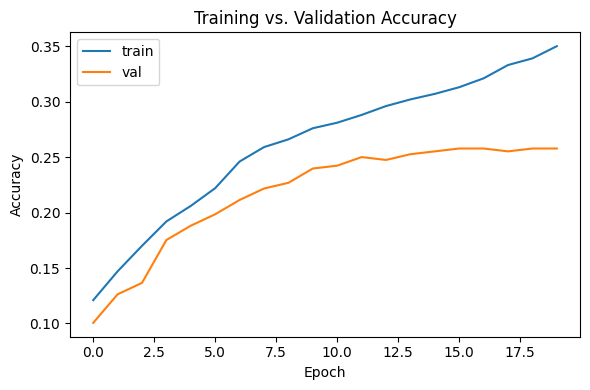

Final validation accuracy: 0.2577

Testing: hidden_layer_sizes=[], activation=relu, optimizer=SGD, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0877 - loss: 2.4441 - val_accuracy: 0.0954 - val_loss: 2.3850
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1092 - loss: 2.3785 - val_accuracy: 0.1005 - val_loss: 2.3407
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1097 - loss: 2.3441 - val_accuracy: 0.1057 - val_loss: 2.3146
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1178 - loss: 2.3239 - val_accuracy: 0.1237 - val_loss: 2.2979
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1318 - loss: 2.3107 - val_accuracy: 0.1211 - val_loss: 2.2863
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1392 - loss: 2.3011 - val_accuracy: 0.1211 - val_loss: 2.2775
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - ac

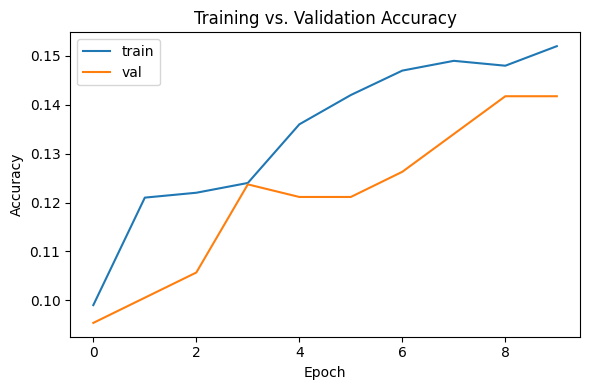

Final validation accuracy: 0.1418

Testing: hidden_layer_sizes=[], activation=relu, optimizer=SGD, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1397 - loss: 2.3528 - val_accuracy: 0.1340 - val_loss: 2.3245
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1446 - loss: 2.3127 - val_accuracy: 0.1289 - val_loss: 2.2978
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1418 - loss: 2.2918 - val_accuracy: 0.1366 - val_loss: 2.2833
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1585 - loss: 2.2802 - val_accuracy: 0.1521 - val_loss: 2.2748
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1558 - loss: 2.2730 - val_accuracy: 0.1521 - val_loss: 2.2690
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1629 - loss: 2.2678 - val_accuracy: 0.1572 - val_loss: 2.2644
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - ac

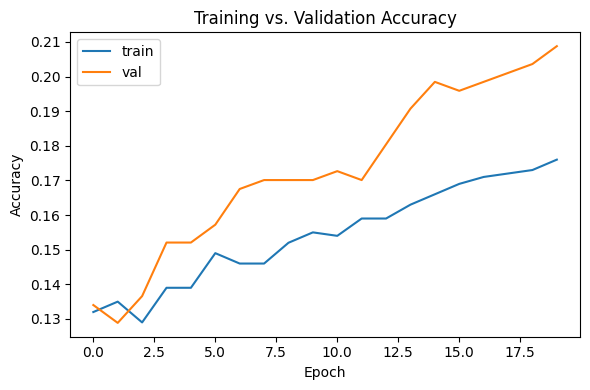

Final validation accuracy: 0.2088

Testing: hidden_layer_sizes=[], activation=tanh, optimizer=Adam, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1092 - loss: 4.4542 - val_accuracy: 0.2036 - val_loss: 2.4878
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2280 - loss: 2.6082 - val_accuracy: 0.2268 - val_loss: 2.1302
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3341 - loss: 2.0083 - val_accuracy: 0.2294 - val_loss: 2.1196
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3802 - loss: 1.8265 - val_accuracy: 0.2500 - val_loss: 2.1255
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3963 - loss: 1.6875 - val_accuracy: 0.2423 - val_loss: 2.1318
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4205 - loss: 1.6361 - val_accuracy: 0.2526 - val_loss: 2.1283
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - ac

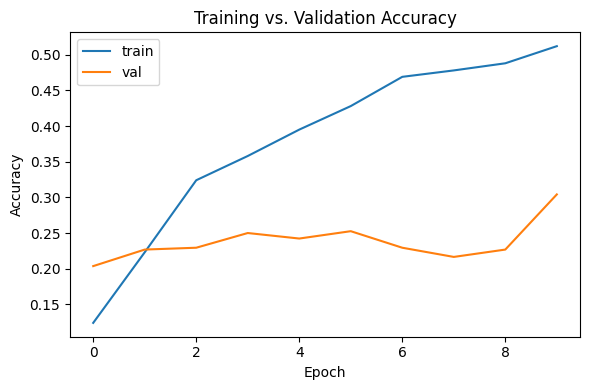

Final validation accuracy: 0.3041

Testing: hidden_layer_sizes=[], activation=tanh, optimizer=Adam, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1247 - loss: 3.8478 - val_accuracy: 0.1469 - val_loss: 2.6647
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2584 - loss: 2.2641 - val_accuracy: 0.2552 - val_loss: 2.0732
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3502 - loss: 1.9043 - val_accuracy: 0.2088 - val_loss: 2.0875
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3558 - loss: 1.7922 - val_accuracy: 0.2294 - val_loss: 2.0945
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3957 - loss: 1.7168 - val_accuracy: 0.2268 - val_loss: 2.1264
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4152 - loss: 1.6477 - val_accuracy: 0.2294 - val_loss: 2.1101
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - ac

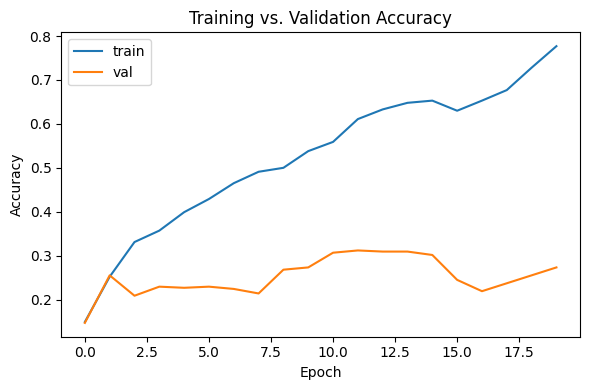

Final validation accuracy: 0.2732

Testing: hidden_layer_sizes=[], activation=tanh, optimizer=Adam, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1160 - loss: 2.3724 - val_accuracy: 0.1366 - val_loss: 2.2343
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1976 - loss: 2.1889 - val_accuracy: 0.1546 - val_loss: 2.1954
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2108 - loss: 2.1347 - val_accuracy: 0.2165 - val_loss: 2.1133
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2666 - loss: 2.0289 - val_accuracy: 0.2448 - val_loss: 2.0640
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3020 - loss: 1.9749 - val_accuracy: 0.2552 - val_loss: 2.0564
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3143 - loss: 1.9430 - val_accuracy: 0.2629 - val_loss: 2.0494
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - a

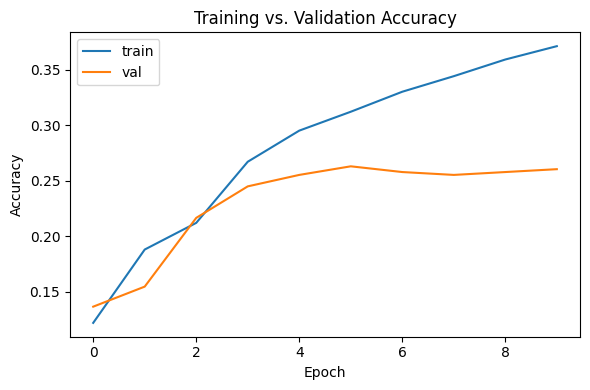

Final validation accuracy: 0.2603

Testing: hidden_layer_sizes=[], activation=tanh, optimizer=Adam, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1060 - loss: 2.3914 - val_accuracy: 0.1521 - val_loss: 2.2217
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1895 - loss: 2.1973 - val_accuracy: 0.1881 - val_loss: 2.1899
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2030 - loss: 2.1136 - val_accuracy: 0.2216 - val_loss: 2.1125
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2753 - loss: 2.0207 - val_accuracy: 0.2165 - val_loss: 2.0780
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3141 - loss: 1.9727 - val_accuracy: 0.2010 - val_loss: 2.0692
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3282 - loss: 1.9382 - val_accuracy: 0.1881 - val_loss: 2.0587
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - a

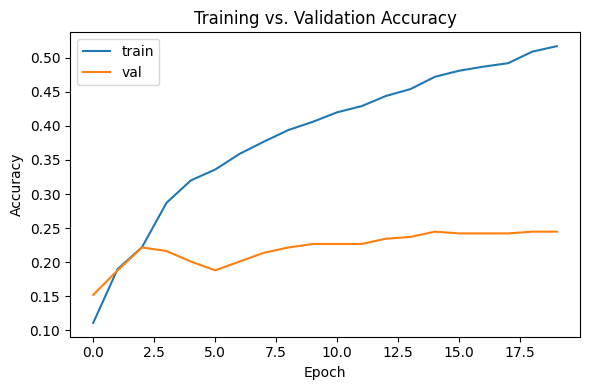

Final validation accuracy: 0.2448

Testing: hidden_layer_sizes=[], activation=tanh, optimizer=SGD, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1346 - loss: 2.3470 - val_accuracy: 0.1804 - val_loss: 2.2373
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1216 - loss: 2.2784 - val_accuracy: 0.1985 - val_loss: 2.2002
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1466 - loss: 2.2350 - val_accuracy: 0.2010 - val_loss: 2.1703
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1758 - loss: 2.1985 - val_accuracy: 0.1985 - val_loss: 2.1458
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1967 - loss: 2.1675 - val_accuracy: 0.2010 - val_loss: 2.1255
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2047 - loss: 2.1406 - val_accuracy: 0.1985 - val_loss: 2.1084
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc

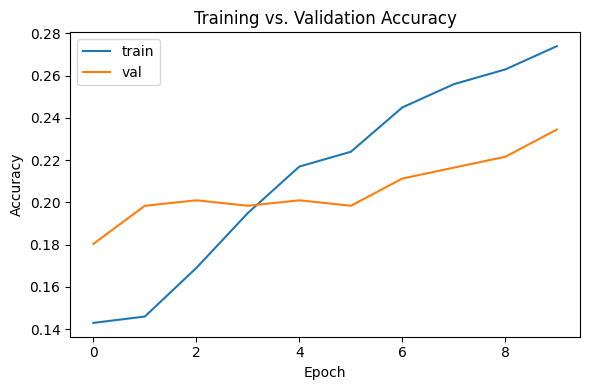

Final validation accuracy: 0.2345

Testing: hidden_layer_sizes=[], activation=tanh, optimizer=SGD, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1064 - loss: 2.3576 - val_accuracy: 0.1160 - val_loss: 2.2665
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1670 - loss: 2.2581 - val_accuracy: 0.1418 - val_loss: 2.2249
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2155 - loss: 2.2139 - val_accuracy: 0.1598 - val_loss: 2.1919
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2253 - loss: 2.1774 - val_accuracy: 0.1778 - val_loss: 2.1653
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2365 - loss: 2.1465 - val_accuracy: 0.1753 - val_loss: 2.1435
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2419 - loss: 2.1199 - val_accuracy: 0.1856 - val_loss: 2.1254
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc

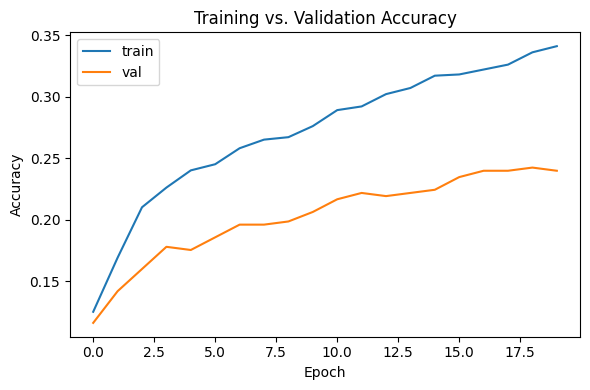

Final validation accuracy: 0.2397

Testing: hidden_layer_sizes=[], activation=tanh, optimizer=SGD, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0897 - loss: 2.4158 - val_accuracy: 0.0799 - val_loss: 2.3792
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1023 - loss: 2.3676 - val_accuracy: 0.0851 - val_loss: 2.3448
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1035 - loss: 2.3414 - val_accuracy: 0.0954 - val_loss: 2.3242
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1087 - loss: 2.3255 - val_accuracy: 0.1186 - val_loss: 2.3109
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1169 - loss: 2.3148 - val_accuracy: 0.1160 - val_loss: 2.3013
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1231 - loss: 2.3067 - val_accuracy: 0.1237 - val_loss: 2.2938
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - ac

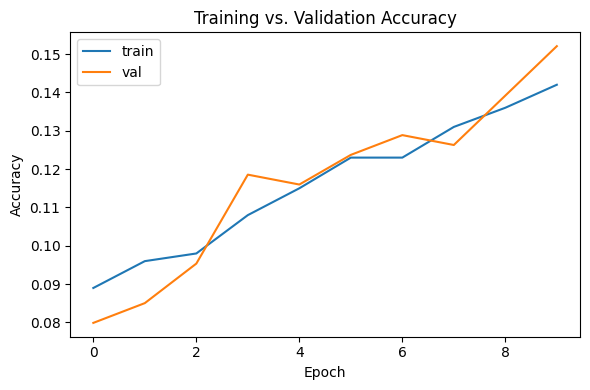

Final validation accuracy: 0.1521

Testing: hidden_layer_sizes=[], activation=tanh, optimizer=SGD, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1109 - loss: 2.4920 - val_accuracy: 0.1057 - val_loss: 2.4258
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1089 - loss: 2.4059 - val_accuracy: 0.1082 - val_loss: 2.3773
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1070 - loss: 2.3650 - val_accuracy: 0.1031 - val_loss: 2.3522
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1044 - loss: 2.3417 - val_accuracy: 0.1031 - val_loss: 2.3377
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1067 - loss: 2.3269 - val_accuracy: 0.1082 - val_loss: 2.3283
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1004 - loss: 2.3165 - val_accuracy: 0.1031 - val_loss: 2.3216
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - ac

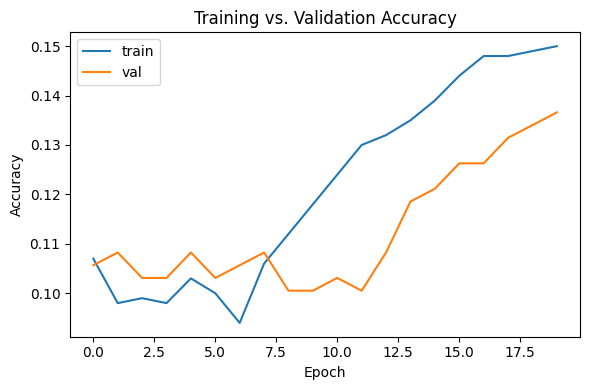

Final validation accuracy: 0.1366

Grid search results:


,hidden_layer_sizes,activation,optimizer,learning_rate,num_epochs,train_acc,val_acc,overfit_gap
0,"[1024, 512]",relu,Adam,0.0010,10,0.437,0.283505,0.153495
1,"[1024, 512]",relu,Adam,0.0010,20,0.672,0.229381,0.442619
2,"[1024, 512]",relu,Adam,0.0001,10,0.468,0.296392,0.171608
3,"[1024, 512]",relu,Adam,0.0001,20,0.667,0.260309,0.406691
4,"[1024, 512]",relu,SGD,0.0010,10,0.168,0.175258,-0.007258
...,...,...,...,...,...,...,...,...
59,[],tanh,Adam,0.0001,20,0.507,0.244845,0.262155
60,[],tanh,SGD,0.0010,10,0.281,0.234536,0.046464
61,[],tanh,SGD,0.0010,20,0.345,0.239691,0.105309
62,[],tanh,SGD,0.0001,10,0.146,0.152062,-0.006062



Best configuration (not overfitted):
{'hidden_layer_sizes': [256], 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.001, 'num_epochs': 20, 'train_acc': 0.257999986410141, 'val_acc': 0.25, 'overfit_gap': 0.007999986410140991}


In [18]:
import itertools
import pandas as pd

# Define parameter grid
hidden_layer_sizes_list = [
    [1024, 512],
    [512, 256], 
    [256],
    []
]
activations = ['relu', 'tanh']
optimizers = ['Adam', 'SGD']
learning_rates = [1e-3, 1e-4]
num_epochs_list = [10, 20]

results = []

for hls, act, opt, lr, ne in itertools.product(
        hidden_layer_sizes_list, activations, optimizers, learning_rates, num_epochs_list):

    print(f"\nTesting: hidden_layer_sizes={hls}, activation={act}, optimizer={opt}, learning_rate={lr}, num_epochs={ne}")
    
    try:
        model = train_and_evaluate(
            X_train_sub, y_train_sub_encoded,
            X_val_sub,   y_val_sub_encoded,
            hidden_layer_sizes=hls,
            activation=act,
            optimizer=opt,
            learning_rate=lr,
            num_epochs=ne
        )
        
        # Evaluate on train and val to check for overfitting
        train_loss, train_acc = model.evaluate(X_train_sub, y_train_sub_encoded, verbose=0)
        val_loss, val_acc = model.evaluate(X_val_sub, y_val_sub_encoded, verbose=0)
        overfit_gap = train_acc - val_acc

        results.append({
            'hidden_layer_sizes': hls,
            'activation': act,
            'optimizer': opt,
            'learning_rate': lr,
            'num_epochs': ne,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'overfit_gap': overfit_gap,
            'model': model  # Consider storing only weights: model.get_weights()
        })
        
    except Exception as e:
        print(f"Error with configuration: {e}")
        continue

# Create DataFrame (excluding model objects)
results_df = pd.DataFrame([
    {k: v for k, v in r.items() if k != 'model'} for r in results
])

print("\nGrid search results:")
display(results_df)

# Find best model (not overfitted)
filtered = results_df[results_df['overfit_gap'] < 0.05]
if not filtered.empty:
    best_idx = filtered['val_acc'].idxmax()
else:
    best_idx = results_df['val_acc'].idxmax()

best_row = results_df.loc[best_idx]
best = results[best_idx]

print("\nBest configuration (not overfitted):")
print(best_row.to_dict())

model = best['model']

In [18]:
results_df.to_csv("results_df_unaugmented.csv", index=False)

In [23]:
results_df

,hidden_layer_sizes,activation,optimizer,learning_rate,num_epochs,train_acc,val_acc,overfit_gap
0,"[1024, 512]",relu,Adam,0.0010,10,0.437,0.283505,0.153495
1,"[1024, 512]",relu,Adam,0.0010,20,0.672,0.229381,0.442619
2,"[1024, 512]",relu,Adam,0.0001,10,0.468,0.296392,0.171608
3,"[1024, 512]",relu,Adam,0.0001,20,0.667,0.260309,0.406691
4,"[1024, 512]",relu,SGD,0.0010,10,0.168,0.175258,-0.007258
...,...,...,...,...,...,...,...,...
59,[],tanh,Adam,0.0001,20,0.507,0.244845,0.262155
60,[],tanh,SGD,0.0010,10,0.281,0.234536,0.046464
61,[],tanh,SGD,0.0010,20,0.345,0.239691,0.105309
62,[],tanh,SGD,0.0001,10,0.146,0.152062,-0.006062


Takeaways:
1. Dense nets overfit quickly - there are huge training gaps as there are only 1000 training images. 
2. Lower learning rates help with generalization
3. ReLu and tanh cap out at about 30% when not fitting

Compared the tbaseline (which is about 28% accuracy) the below is the best on this small subset:

hidden_layer_sizes : [1024, 512]
activation         : relu
optimizer          : Adam
learning_rate      : 1e-4
num_epochs         : 10
train_acc          : 0.468
val_acc            : 0.296
overfit_gap        : 0.172

So these extra hidden layers don't contribute very much - mostly overfitting.


# Stage 2.5: Fully connected neural network (Full Data w/ Augmentation)

In [ ]:
def build_model(n_classes,
                input_shape=(64, 64, 3),
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01,
                metric='metric'):
    """Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of output classes in the dataset.
    input_shape: Shape of input images (height, width, channels).
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.
    metric: The desired metric.

    Returns:
    model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    model = tf.keras.Sequential()
    
    # Change this line to use the input_shape parameter
    model.add(tf.keras.layers.Input(shape=input_shape, name='Input'))
    
    model.add(tf.keras.layers.Flatten(name='Flatten')) #Flatten the input

    for i, units in enumerate(hidden_layer_sizes):
        model.add(tf.keras.layers.Dense(units, activation=activation, name=f"Hidden_{i+1}"))

    model.add(tf.keras.layers.Dense(
        n_classes,
        activation='softmax',
        name='Output',
        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.01)
    ))

    if optimizer == 'SGD':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'Adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise ValueError(f'Unsupported optimizer: {optimizer}')

    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=opt,
        metrics=[metric]
    )

    return model

In [ ]:
def train_and_evaluate(X_train, y_train,
                       X_val,   y_val,
                       hidden_layer_sizes=None,
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=1e-3,
                       metric='accuracy',
                       num_epochs=10,
                       batch_size=64):
    """
    Train a dense network (or logistic-regression baseline) on Stanford Dogs data.

    Parameters
    ----------
    X_train, y_train : np.ndarray
        Training images and integer labels.
    X_val,   y_val   : np.ndarray
        Validation images and integer labels.  (Use this again as "test" until you
        create a proper hold-out set.)
    hidden_layer_sizes : list[int] | None
        Example []  -> logistic regression
                [1024, 512] -> two-layer dense net.
    activation : str
        Activation for hidden layers.  ('relu', 'tanh', …)
    optimizer : str
        'Adam' or 'SGD'
    learning_rate : float
        Learning-rate passed to the chosen optimizer.
    metric : str
        Metric name understood by Keras, e.g. 'accuracy'.
    num_epochs : int
        Training epochs.
    batch_size : int
        Mini-batch size.

    Returns
    -------
    model : tf.keras.Model
    """
    hidden_layer_sizes = hidden_layer_sizes or []

    # ------------------------------------------------------------------
    # 1.  Build the model.  n_classes inferred from the label array.
    # ------------------------------------------------------------------
    n_classes = len(np.unique(y_train))
    model = build_model(n_classes=n_classes,
                        hidden_layer_sizes=hidden_layer_sizes,
                        activation=activation,
                        optimizer=optimizer,
                        learning_rate=learning_rate,
                        metric=metric)

    # ------------------------------------------------------------------
    # 2.  Train
    # ------------------------------------------------------------------
    print("Training on %d images, validating on %d images ..."
          % (len(X_train), len(X_val)))

    history = model.fit(
        X_train, y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1
    )

    # ------------------------------------------------------------------
    # 3.  Learning curves
    # ------------------------------------------------------------------
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Validation Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------------
    # 4.  Final metrics on the validation set
    # ------------------------------------------------------------------
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"Final validation accuracy: {val_acc:.4f}")

    return model

# Stage 3: Fully connected neural network (Full Data)

In [8]:
# Convert string labels to integers for all classes
from sklearn.preprocessing import LabelEncoder

# Fit the encoder on all training labels (including all classes)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

print(f"Number of unique classes: {len(label_encoder.classes_)}")
print(f"Classes: {label_encoder.classes_}")

Number of unique classes: 120
Classes: ['affenpinscher' 'afghan_hound' 'african_hunting_dog' 'airedale'
 'american_staffordshire_terrier' 'appenzeller' 'australian_terrier'
 'basenji' 'basset' 'beagle' 'bedlington_terrier' 'bernese_mountain_dog'
 'black' 'blenheim_spaniel' 'bloodhound' 'bluetick' 'border_collie'
 'border_terrier' 'borzoi' 'boston_bull' 'bouvier_des_flandres' 'boxer'
 'brabancon_griffon' 'briard' 'brittany_spaniel' 'bull_mastiff' 'cairn'
 'cardigan' 'chesapeake_bay_retriever' 'chihuahua' 'chow' 'clumber'
 'cocker_spaniel' 'collie' 'curly' 'dandie_dinmont' 'dhole' 'dingo'
 'doberman' 'english_foxhound' 'english_setter' 'english_springer'
 'entlebucher' 'eskimo_dog' 'flat' 'french_bulldog' 'german_shepherd'
 'german_short' 'giant_schnauzer' 'golden_retriever' 'gordon_setter'
 'great_dane' 'great_pyrenees' 'greater_swiss_mountain_dog' 'groenendael'
 'ibizan_hound' 'irish_setter' 'irish_terrier' 'irish_water_spaniel'
 'irish_wolfhound' 'italian_greyhound' 'japanese_spaniel'

Training on 12000 images, validating on 4290 images ...
Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.0117 - loss: 4.8315 - val_accuracy: 0.0159 - val_loss: 4.6394
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.0173 - loss: 4.6225 - val_accuracy: 0.0203 - val_loss: 4.5871
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.0223 - loss: 4.5495 - val_accuracy: 0.0263 - val_loss: 4.5026
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.0309 - loss: 4.4432 - val_accuracy: 0.0298 - val_loss: 4.4512
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.0333 - loss: 4.3950 - val_accuracy: 0.0266 - val_loss: 4.4642
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.0391 - loss: 4.3468 - val_accuracy: 0.0277 - val_loss: 4.4745
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.0423 - loss: 4.3084 - val_accuracy: 0.0273 - val_loss: 4.5885
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━

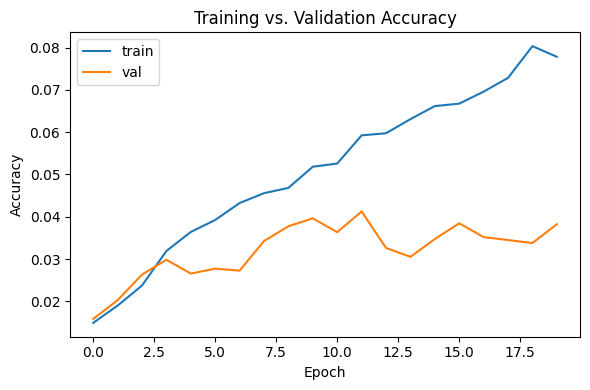

Final validation accuracy: 0.0382


In [ ]:
# Train the model on the full dataset
model_full = train_and_evaluate(
    X_train, y_train_encoded,
    X_val, y_val_encoded,
    hidden_layer_sizes=[1024, 512],
    activation='relu',
    optimizer='Adam',
    learning_rate=1e-3,
    num_epochs=20
)

Poor (but better than random which would be ~0.8%). The model is now underfitting, and we still lack spatial inductive bias. (Doesn't recognize ear shape etc.)

## Hyperparameter Tuning

Starting quick grid search with 12 combinations
Estimated time: 20-40 minutes

Testing: hidden_layer_sizes=[1024, 512], learning_rate=0.001, num_epochs=10

Training on 12000 images, validating on 4290 images ...
Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.0137 - loss: 4.8244 - val_accuracy: 0.0170 - val_loss: 4.6382
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.0170 - loss: 4.6237 - val_accuracy: 0.0172 - val_loss: 4.6072
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.0184 - loss: 4.5728 - val_accuracy: 0.0245 - val_loss: 4.5740
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.0274 - loss: 4.5296 - val_accuracy: 0.0235 - val_loss: 4.5308
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 101ms/step - accuracy: 0.0280 - loss: 4.4529 - val_accuracy: 0.0254 - val_loss: 4.5023
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.0346 - loss: 4.3805 - val_accuracy: 0.0303 - val_loss: 4.4503
Epoch 

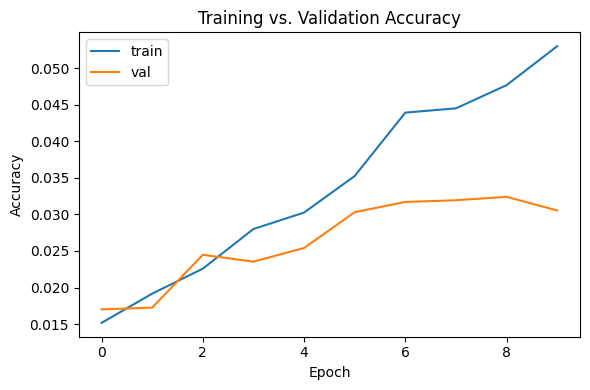

Final validation accuracy: 0.0305
✅ Train Acc: 0.0411, Val Acc: 0.0305, Overfit Gap: 0.0105

Testing: hidden_layer_sizes=[1024, 512], learning_rate=0.001, num_epochs=15
Training on 12000 images, validating on 4290 images ...
Epoch 1/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.0098 - loss: 4.8241 - val_accuracy: 0.0152 - val_loss: 4.6396
Epoch 2/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.0183 - loss: 4.6178 - val_accuracy: 0.0203 - val_loss: 4.6006
Epoch 3/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.0213 - loss: 4.5778 - val_accuracy: 0.0177 - val_loss: 4.6006
Epoch 4/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.0202 - loss: 4.5584 - val_accuracy: 0.0207 - val_loss: 4.5723
Epoch 5/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - accuracy: 0.0235 - loss: 4.5130 - val_accuracy: 0.0228 - val_loss: 4.5449
Epoch 6/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.0318 - loss: 4.4458 - val_accuracy: 0.0301 - val_loss: 4.

KeyboardInterrupt: 

In [9]:
# FAST parameter grid (only 12 combinations) - NO DROPOUT
hidden_layer_sizes_list = [
    [1024, 512],      # Deep network
    [512, 256],       # Medium network  
    [512]             # Single layer
]

learning_rates = [1e-3, 1e-4]  # Just 2 learning rates
batch_sizes = [64]             # Single batch size
num_epochs_list = [10, 15]     # Fewer epochs

results = []

total_combinations = len(hidden_layer_sizes_list) * len(learning_rates) * len(batch_sizes) * len(num_epochs_list)
print(f"Starting quick grid search with {total_combinations} combinations")
print("Estimated time: 20-40 minutes")

for hls, lr, bs, ne in itertools.product(
        hidden_layer_sizes_list, learning_rates, batch_sizes, num_epochs_list):

    print(f"\nTesting: hidden_layer_sizes={hls}, learning_rate={lr}, num_epochs={ne}")
    
    try:
        model = train_and_evaluate(
            X_train, y_train_encoded,
            X_val, y_val_encoded,
            hidden_layer_sizes=hls,
            activation='relu',
            optimizer='Adam',
            learning_rate=lr,
            num_epochs=ne,
            batch_size=bs
            # No dropout_rate parameter
        )
        
        # Quick evaluation
        train_loss, train_acc = model.evaluate(X_train, y_train_encoded, verbose=0, batch_size=bs)
        val_loss, val_acc = model.evaluate(X_val, y_val_encoded, verbose=0, batch_size=bs)
        overfit_gap = train_acc - val_acc

        results.append({
            'hidden_layer_sizes': hls,
            'learning_rate': lr,
            'num_epochs': ne,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'overfit_gap': overfit_gap,
            'model': model
        })
        
        print(f"✅ Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Overfit Gap: {overfit_gap:.4f}")
        
    except Exception as e:
        print(f"❌ Error with configuration: {e}")
        continue

# Create DataFrame
results_df = pd.DataFrame([
    {k: v for k, v in r.items() if k != 'model'} for r in results
])

print("\nQuick Grid Search Results:")
display(results_df)

# Find best model
best_idx = results_df['val_acc'].idxmax()
best_row = results_df.loc[best_idx]
best_model = results[best_idx]['model']

print("\n�� Best Configuration:")
print(best_row.to_dict())

# Save best model
best_model.save('best_full_model_quick.keras')
print("Best model saved as 'best_full_model_quick.keras'")

# Quick visualization
plt.figure(figsize=(10, 4))

# Plot 1: Validation Accuracy by configuration
plt.subplot(1, 2, 1)
configs = [f"{row['hidden_layer_sizes']}\nLR={row['learning_rate']}\nEpochs={row['num_epochs']}" 
           for _, row in results_df.iterrows()]
plt.bar(range(len(configs)), results_df['val_acc'])
plt.xticks(range(len(configs)), configs, rotation=45, ha='right')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy by Configuration')
plt.ylim(0, 1)

# Plot 2: Overfitting analysis
plt.subplot(1, 2, 2)
plt.scatter(results_df['overfit_gap'], results_df['val_acc'], s=100, alpha=0.7)
plt.xlabel('Overfitting Gap (Train - Val Acc)')
plt.ylabel('Validation Accuracy')
plt.title('Overfitting vs Performance')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n�� Summary:")
print(f"Best validation accuracy: {best_row['val_acc']:.4f}")
print(f"Best overfitting gap: {best_row['overfit_gap']:.4f}")
print(f"Configuration: {best_row['hidden_layer_sizes']}, LR={best_row['learning_rate']}, Epochs={best_row['num_epochs']}")